<a href="https://colab.research.google.com/github/petitmeau/SLURP-optimization/blob/main/1SurfactantSLURP_best_predictors_clem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Introduction
Lung ultrasound (LU) use is increasingly recommended by international expert societies 1,2 for the management of sick neonates. It serves as a valuable tool for diagnosing neonatal respiratory distress, guiding procedures such as drain insertion, and supporting clinical decisions like predicting the need for surfactant administration using lung ultrasound scores (LUS) 1,3 . Several studies and meta-analyses have demonstrated the high performance of a six-region LUS in predicting the need for surfactant in preterm infants born at ≤ 34 weeks of gestation (4-6), as well as in near-term and term infants admitted to NICUs with persistent respiratory distress 7. However, the rationale behind selecting these six regions remains unclear and lacks data-driven validation.
On the other hand, SLURP study is a prospective cohort study conducted in the UK, including preterm neonates born at ≤ 34 weeks' gestation, stabilized on CPAP at birth, who underwent LUS within the first 3 hours of life and prior to surfactant administration. Although the model showed good accuracy (AUC 0.8), scoring was done by a single expert, and inter-rater agreement with learners was only fair, indicating a challenge in consistent LUS scoring.
We hypothesized that the predictive value of each of the six regions varies based on gravity, respiratory support, and heterogeneity of neonatal lung pathology 8. The objective of our study was to analyse regional LUS data and explore whether machine learning models could help derive a simpler, data-driven, and accurate score to predict surfactant administration in preterm neonates, particularly useful for learners.





# Rationale for the study:
We hypothesized that the predictive value of each of the six regions varies based on gravity, respiratory support, and heterogeneity of neonatal lung pathology 8.

# Objective of the study:
The objective of our study was to analyse regional LUS data and explore whether machine learning models could help derive a simpler, data-driven, and accurate score to predict surfactant administration in preterm neonates, particularly useful for learners.

# Methodology
This study is part of the SLURP study (Serial Lung Ultrasound for Surfactant Replacement Therapy), a prospective observational study conducted in three UK NICUs: James Cook University Hospital (JCUH), University Hospital Wishaw (UHW), and Oliver Fisher Neonatal Unit (OFNU). The primary aim was to assess the diagnostic value of six- and ten-region LUS performed within the first 3 hours of life by clinicians with different levels of experience, to predict surfactant administration in preterm infants ≤ 34 weeks on non-invasive support.
Eighty-three inborn preterm infants receiving non-invasive respiratory support at birth were recruited. Exclusion criteria included infants intubated in the delivery room or before the first LU, major congenital malformations, and pneumothorax requiring intervention. For this analysis, only the initial scan before surfactant administration or within 3 hours of life was included.
LU involved assessing five zones per lung (10 total): Upper Anterior, Lower Anterior, Lateral, Upper Posterior, and Lower Posterior. Infants were briefly tilted based on clinical stability to access posterior regions. A scoring system adapted from Brat et al. was used, assigning scores from 0 to 3 based on defined LU patterns. The six-region score included two anterior and one lateral region per lung (max score 18); the ten-region score included all five regions per lung (max score 50).
Clinical teams followed local respiratory guidelines, generally based on European RDS management standards. LU findings were not shared with treating teams, except in pneumothorax cases. All scans were reviewed and scored by an expert blinded to clinical data. Data was managed using REDCap.


Data analysis and features selection:
We extracted the following features for analysis: gestational age (GA), LU pattern diagnosis, six- and ten-region scores, individual region scores (R1-R5, L1-L5), and surfactant administration status. Analyses were performed using python on Google Colab Pro environment. Cases with missing data were excluded.
Univariate analysis was visualized with histograms. Bivariate analysis used Spearman correlation heatmaps to evaluate relationships between regions and surfactant administration. We examined individual regional performance and combinations (2-4 regions) for accuracy, sensitivity and specificity, ensuring low multicollinearity. Unsupervised learning (PCA) identified regions most associated with surfactant need. We tested several combinations and thresholds to find the most effective scoring subsets.
Model development:
Predictive models were compared to the traditional six-region score. Performance metrics included accuracy, sensitivity, specificity, Youden index, false negative rate, and AUC. We tested rule-based models, decision trees (DT), logistic regression (LRM), random forest (RF) and gradient boosting (GB). Feature selection was optimized per model to enhance predictive accuracy.
Models were validated across subgroups (≤ 30 weeks, >30 weeks) and an independent test cohort.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Importing necessary modules: the usual suspects!
%matplotlib inline
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import numpy as np
import pandas as pd
import pydotplus


import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import cluster, decomposition, pipeline, preprocessing, tree
import statsmodels

from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

#import fancyimpute
import missingno as mn

import io
import urllib.request as req
import zipfile

import warnings
warnings.filterwarnings("ignore")

# Import and process the data

In [ ]:
#Import data
df = pd.read_excel('/content/drive/MyDrive/SLURP/LU_only_Working Slurp mistakes.xlsx')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
3,2,RDS,na,na,1,28,1,2,1,2,2,NaN,NaN,NaN,2,2
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3


In [ ]:
# Remove unnecessary first row
df = df.iloc[1:]
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
3,2,RDS,na,na,1,28,1,2,1,2,2,NaN,NaN,NaN,2,2
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0


In [ ]:
# define first row as columns names
df.columns = df.iloc[0]
df.head()

1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
3,2,RDS,na,na,1,28,1,2,1,2,2,NaN,NaN,NaN,2,2
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0


In [ ]:
# Remove first row
df = df.iloc[1:]
df.head()

1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
3,2,RDS,na,na,1,28,1,2,1,2,2,NaN,NaN,NaN,2,2
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0
6,5,RDS,10,18,0,32,2,1,2,2,2,1,2,2,2,2


In [ ]:
# Make a copy
df1 = df.copy()
df1.head()

1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
3,2,RDS,na,na,1,28,1,2,1,2,2,NaN,NaN,NaN,2,2
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0
6,5,RDS,10,18,0,32,2,1,2,2,2,1,2,2,2,2


In [ ]:
#remove rows with missing data
df1 = df1.dropna()
df1.head()

1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0
6,5,RDS,10,18,0,32,2,1,2,2,2,1,2,2,2,2
7,6,TTN,1,1,0,31,0,1,0,0,0,0,0,0,0,0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 2 to 87
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Cases                  78 non-null     object
 1   Diagnosis on patterns  78 non-null     object
 2   6 regions              78 non-null     object
 3   10 regions             78 non-null     object
 4   Surfactant             78 non-null     object
 5   GA                     78 non-null     object
 6   R1                     78 non-null     object
 7   R2                     78 non-null     object
 8   R3                     78 non-null     object
 9   R4                     78 non-null     object
 10  R5                     78 non-null     object
 11  L1                     78 non-null     object
 12  L2                     78 non-null     object
 13  L3                     78 non-null     object
 14  L4                     78 non-null     object
 15  L5                     78 non-

In [ ]:
# convert all features except Diagnosis on patterns into integer
columns_to_convert = ['6 regions', '10 regions', 'Surfactant', 'GA', 'R1', 'R2', 'R3', 'R4', 'R5', 'L1','L2', 'L3', 'L4','L5']
# Replace 'na' with NaN and then convert to numeric
df1[columns_to_convert] = df1[columns_to_convert].replace('na', np.nan).astype(float).astype(pd.Int64Dtype())
#using pd.Int64Dtype() to allow for integer with Nan without converting to float
df1.head()

1,Cases,Diagnosis on patterns,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
2,1,RDS,10,19,1,29,2,2,2,2,2,1,1,2,2,3
4,3,RDS,12,22,1,26,2,2,2,2,2,2,2,2,3,3
5,4,TTN,6,7,0,33,1,1,1,0,0,1,1,1,1,0
6,5,RDS,10,18,0,32,2,1,2,2,2,1,2,2,2,2
7,6,TTN,1,1,0,31,0,1,0,0,0,0,0,0,0,0


In [ ]:
df1 = df1.dropna(subset=['6 regions'])

# Data analysis

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 2 to 87
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Cases                  77 non-null     object
 1   Diagnosis on patterns  77 non-null     object
 2   6 regions              77 non-null     Int64 
 3   10 regions             76 non-null     Int64 
 4   Surfactant             77 non-null     Int64 
 5   GA                     77 non-null     Int64 
 6   R1                     77 non-null     Int64 
 7   R2                     77 non-null     Int64 
 8   R3                     77 non-null     Int64 
 9   R4                     77 non-null     Int64 
 10  R5                     77 non-null     Int64 
 11  L1                     77 non-null     Int64 
 12  L2                     77 non-null     Int64 
 13  L3                     77 non-null     Int64 
 14  L4                     77 non-null     Int64 
 15  L5                     77 non-

In [ ]:
# description for categorical values
df1.describe(include='object')

1,Cases,Diagnosis on patterns
count,77,77
unique,77,3
top,1,RDS
freq,1,44


In [ ]:
df1 = df1.reset_index(drop=True)

In [ ]:
# description for integers values
df1.describe()

1,6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5
count,77.0,76.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
mean,7.428571,13.394737,0.376623,30.467532,1.103896,1.194805,1.402597,1.480519,1.480519,1.090909,1.246753,1.415584,1.480519,1.493506
std,3.43139,5.638153,0.487717,2.297507,0.680256,0.688992,0.693195,0.640937,0.718375,0.632077,0.710001,0.675719,0.640937,0.804974
min,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,5.0,9.0,0.0,29.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,8.0,15.0,0.0,31.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0
75%,10.0,18.0,1.0,32.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
max,12.0,22.0,1.0,34.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0


In [ ]:
# capacity of pattern to predict surfactant: x axis is Diagnosis on pattern and y axis is % with surfactant = 1
df1.groupby('Diagnosis on patterns')['Surfactant'].value_counts(normalize=True)


Diagnosis on patterns  Surfactant
RDS                    1             0.568182
                       0             0.431818
TTN                    0             0.866667
                       1             0.133333
nd                     0                  1.0
Name: proportion, dtype: Float64

In [ ]:
# cross table: outcome is surfactant, variable is diagnosis on patterns
pd.crosstab(df1['Diagnosis on patterns'], df1['Surfactant'])

Surfactant,0,1
Diagnosis on patterns,,
RDS,19,25
TTN,26,4
nd,3,0


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df1

# Create a new column '6_regions_group' based on the 6 regions score
df1['6_regions_group'] = pd.cut(df1['6 regions'], bins=[-float('inf'), 9, float('inf')],
                               labels=['<9', '>=9'])

# Create the cross-tabulation
cross_tab = pd.crosstab(df1['6_regions_group'], df1['Surfactant'])

# Display the cross-tabulation
print(cross_tab)

Surfactant        0   1
6_regions_group        
<9               42  11
>=9               6  18


On the 29 patients who received surfactant, 18 were scored properly and 11 were not properly scored

Looking at patients who were diagnosed as TTN and received surfactant, what was the score?

In [ ]:
# 6 regions score for those with TTN as Diagnosis on patterns and surfactant =1
filtered_df = df1[(df1['Diagnosis on patterns'] == 'TTN') & (df1['Surfactant'] == 1)]
six_regions_score = filtered_df['6 regions']
print(six_regions_score.value_counts())  # Get descriptive statistics

6 regions
5    1
4    1
3    1
6    1
Name: count, dtype: Int64


For the 4 patients diagnosed with TTN and who received surfactant, all 4 had a low score. This reflects limitation of LU that whatever the method would have concluded TTN and would not have recommended surfactant

In [ ]:
# how good is diagnosis on patterns to predict Surfactant
pd.crosstab(df1['Diagnosis on patterns'], df1['Surfactant']).apply(lambda r: r/r.sum(), axis=1)

Surfactant,0,1
Diagnosis on patterns,,
RDS,0.431818,0.568182
TTN,0.866667,0.133333
nd,1.000000,0.000000


In [ ]:
# accuracy of diagnosis on pattern to predict surfactant
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1

# Get the true labels for Surfactant
y_true = df1['Surfactant']

# Create a binary prediction based on Diagnosis on patterns = RDS
y_pred = (df1['Diagnosis on patterns'] == 'RDS').astype(int)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.86
Specificity: 0.60


In [ ]:
# accuracy of diagnosis on pattern to predict no surfactant
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1

# Get the true labels for Surfactant
y_true = (df1['Surfactant'] == 0).astype(int)

# Create a binary prediction based on Diagnosis on patterns = RDS
y_pred = (df1['Diagnosis on patterns'] == 'TTN').astype(int)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.54
Specificity: 0.86


As a conclusion, TTN diagnosis pattern is very specific to predict no surfactant, but RDS diagnosis pattern is not specific to predict surfactant administration

# Bivariate analysis

<Axes: xlabel='1', ylabel='1'>

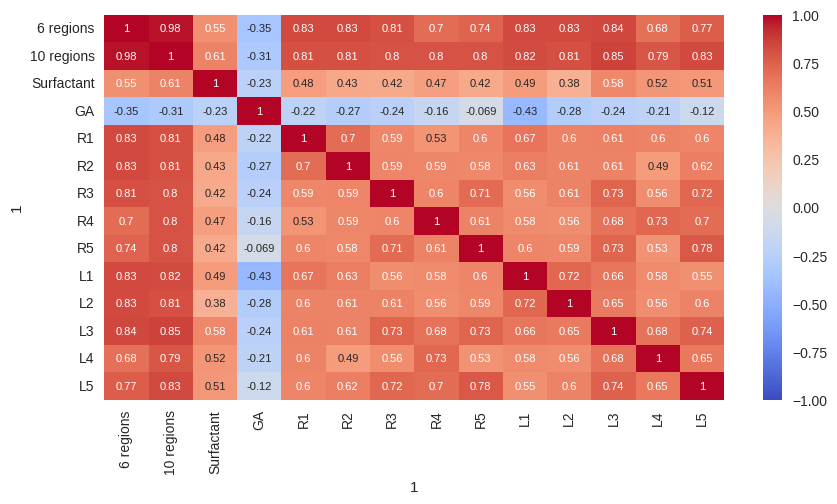

In [ ]:
# bivariate analysis on heatmap: what are the main features associated with surfactant administration
plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(method='spearman', numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 8})


# Exploring regional score for surfactant prediction

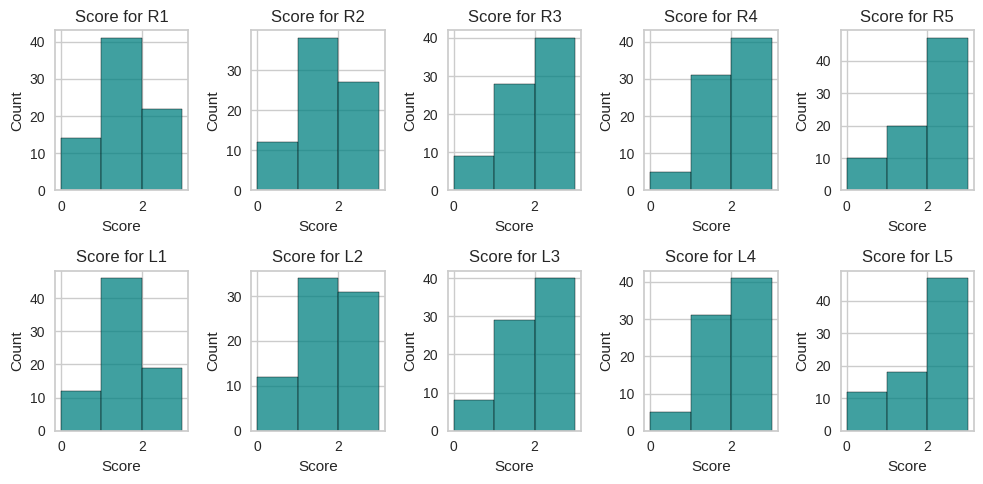

In [ ]:
# look into each region
fig, plt.axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i, region in enumerate(['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5']):
  plt.subplot(2,5,i+1)
  bins = np.arange(0,4,1)
  sns.histplot(df1[region], bins = bins, color = 'teal')
  plt.xlabel('Score')
  plt.ylabel('Count')
  plt.title('Score for {}'.format(region))
  plt.title('Score for {}'.format(region))


  # Adjust the spacing between subplots
  plt.tight_layout()

# Increase vertical spacing between rows
  plt.subplots_adjust(hspace=0.5)  # Adjust 0.5 to your preference

  # Display the figure
plt.show()


The whole population scores are mainly  1 for L1, L2, R1, R2, and score 2 for other areas (axillary and posteriors)

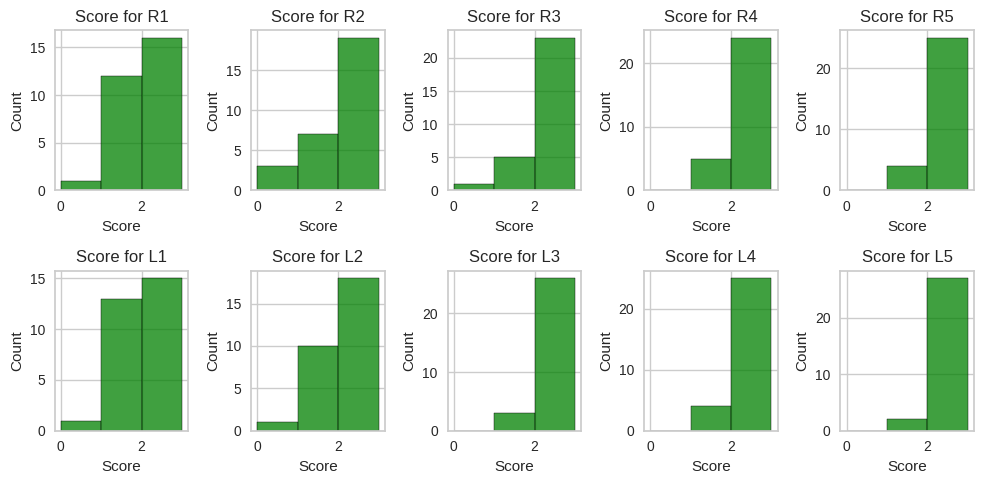

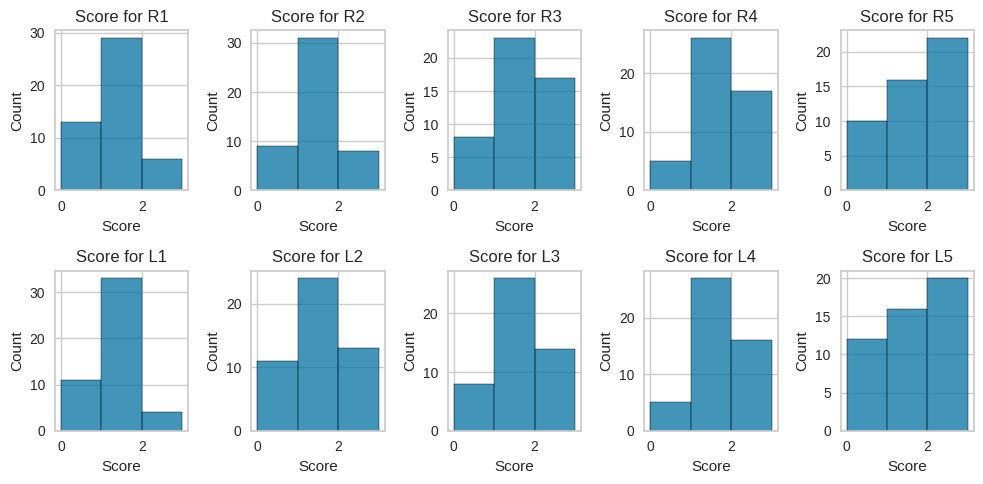

In [ ]:
# For those who surfactant = 0
df1_no_surfactant = df1[df1['Surfactant'] == 0]

# same histograms but only for those who Surfactant = 1
df1_surfactant = df1[df1['Surfactant'] == 1]
# look into each region
fig, plt.axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i, region in enumerate(['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5']):
  plt.subplot(2,5,i+1)
  bins = np.arange(0,4,1)
  sns.histplot(df1_surfactant[region], bins = bins, color='green')
  plt.xlabel('Score')
  plt.ylabel('Count')
  plt.title('Score for {}'.format(region))


  # Adjust the spacing between subplots
  plt.tight_layout()

# Increase vertical spacing between rows
  plt.subplots_adjust(hspace=0.5)  # Adjust 0.5 to your preference

  # Display the figure
plt.show()

# look into each region
fig, plt.axes = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i, region in enumerate(['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5']):
  plt.subplot(2,5,i+1)
  bins = np.arange(0,4,1)
  sns.histplot(df1_no_surfactant[region], bins = bins)
  plt.xlabel('Score')
  plt.ylabel('Count')
  plt.title('Score for {}'.format(region))


  # Adjust the spacing between subplots
  plt.tight_layout()

# Increase vertical spacing between rows
  plt.subplots_adjust(hspace=0.5)  # Adjust 0.5 to your preference

  # Display the figure
plt.show()





Looking for best regions or combinations to predict need for surfactant

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, precision_recall_curve)

In [ ]:
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve

columns = ['method', 'accuracy','sensitivity', 'specificity','Youden index', 'precision', 'f1 score',  'auc', 'auprc', 'fn rate', 'fp rate',]
results = pd.DataFrame(columns=columns)


def get_metrics(y_pred, y_true):
    # Calculate the basic metrics

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

    # False negative rate and false positive rate
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (fp + tn)

    return accuracy, sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate


In [ ]:
df_30_minus = df1[df1['GA'] <= 30]
df_30_plus = df1[df1['GA'] > 30]

# Choose what data you want to study
df = df1.copy()
#df = df_30_minus.copy()
#df = df_30_plus.copy()

In [ ]:
#which are the most predictive regions for surfactant =0
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1
best_accurary= None
best_feature = None
best_accuracy=0
best_fn = 1

for region in ['R1', 'R2', 'R3', 'L1', 'L2', 'L3','L4','L5','R4','R5']:
    # Create a binary prediction based on region = 1 or 1
    y_pred = (df1[region] <= 1 ).astype(int)

    # Get the true labels for Surfactant
    y_true = df1['Surfactant'] == 0

    metrics=get_metrics(y_pred, y_true)

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

    print("Tested region:", region, "-> Accuracy:", accuracy, "Sensitivity:", sensitivity, "Specificity:", specificity)
    print("Tested region:", region, "-> Accuracy:", metrics[0], "Sensitivity:", metrics[1], "Specificity:", metrics[2])



        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region
        best_metrics = metrics

    elif accuracy == best_accuracy and fn < best_fn:
        best_accuracy = accuracy
        best_fn = fn
        best_features = region
        best_metrics = metrics

# Optionally, convert the results into a DataFrame
#results_df = pd.DataFrame(results_list)

print("\nBest feature :", best_features)
print("Best accuracy:", best_accuracy)


Tested region: R1 -> Accuracy: 0.7532467532467533 Sensitivity: 0.875 Specificity: 0.5517241379310345
Tested region: R1 -> Accuracy: 0.7532467532467533 Sensitivity: 0.875 Specificity: 0.5517241379310345
Tested region: R2 -> Accuracy: 0.7662337662337663 Sensitivity: 0.8333333333333334 Specificity: 0.6551724137931034
Tested region: R2 -> Accuracy: 0.7662337662337663 Sensitivity: 0.8333333333333334 Specificity: 0.6551724137931034
Tested region: R3 -> Accuracy: 0.7012987012987013 Sensitivity: 0.6458333333333334 Specificity: 0.7931034482758621
Tested region: R3 -> Accuracy: 0.7012987012987013 Sensitivity: 0.6458333333333334 Specificity: 0.7931034482758621
Tested region: L1 -> Accuracy: 0.7662337662337663 Sensitivity: 0.9166666666666666 Specificity: 0.5172413793103449
Tested region: L1 -> Accuracy: 0.7662337662337663 Sensitivity: 0.9166666666666666 Specificity: 0.5172413793103449
Tested region: L2 -> Accuracy: 0.6883116883116883 Sensitivity: 0.7291666666666666 Specificity: 0.6206896551724138


In [ ]:
#which are the most predictive regions for surfactant =1
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1
best_accurary= None
best_feature = None
best_accuracy=0
best_fn = 1

for region in ['R1', 'R2', 'R3', 'L1', 'L2', 'L3','L4','L5','R4','R5']:
    # Create a binary prediction based on region = 1 or 1
    y_pred = (df1[region] >1 ).astype(int)

    # Get the true labels for Surfactant
    y_true = df1['Surfactant'] == 1

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region
        best_metrics = metrics

    elif accuracy == best_accuracy and fn < best_fn:
        best_accuracy = accuracy
        best_fn = fn
        best_features = region
        best_metrics = metrics

    metrics=get_metrics(y_pred, y_true)

    print("Tested region:", region, "-> Accuracy:", accuracy, "Sensitivity:", sensitivity, "Specificity:", specificity)
    print("Tested region:", region, "-> Accuracy:", metrics[0], "Sensitivity:", metrics[1], "Specificity:", metrics[2])

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region
        best_metrics = metrics

    elif accuracy == best_accuracy and fn < best_fn:
        best_accuracy = accuracy
        best_fn = fn
        best_features = region
        best_metrics = metrics

# Optionally, convert the results into a DataFrame
#results_df = pd.DataFrame(results_list)

print("\nBest feature :", best_features)
print("Best accuracy:", best_accuracy)
print('Best metrics:', best_metrics)


Tested region: R1 -> Accuracy: 0.7532467532467533 Sensitivity: 0.5517241379310345 Specificity: 0.875
Tested region: R1 -> Accuracy: 0.7532467532467533 Sensitivity: 0.5517241379310345 Specificity: 0.875
Tested region: R2 -> Accuracy: 0.7662337662337663 Sensitivity: 0.6551724137931034 Specificity: 0.8333333333333334
Tested region: R2 -> Accuracy: 0.7662337662337663 Sensitivity: 0.6551724137931034 Specificity: 0.8333333333333334
Tested region: R3 -> Accuracy: 0.7012987012987013 Sensitivity: 0.7931034482758621 Specificity: 0.6458333333333334
Tested region: R3 -> Accuracy: 0.7012987012987013 Sensitivity: 0.7931034482758621 Specificity: 0.6458333333333334
Tested region: L1 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666
Tested region: L1 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666
Tested region: L2 -> Accuracy: 0.6883116883116883 Sensitivity: 0.6206896551724138 Specificity: 0.7291666666666666


Bets 2 regions combinations

In [ ]:
#which are the most predictive regions for surfactant =1
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1
best_accurary= None
best_feature = None
best_accuracy=0
best_fn = 1

y_true = df1['Surfactant'] == 1
regions= ['R1', 'R2', 'R3', 'L1', 'L2', 'L3','L4','L5','R4','R5']

   # Iterate through all combinations of two regions
for region_pair in combinations(regions, 2):
    region1, region2 = region_pair

    # Create a binary prediction based on both regions <= 1
    y_pred = ((df1[region1] >1) & (df1[region2]>1)).astype(int)

    metrics=get_metrics(y_pred, y_true)

    print(f"Regions: {region1}, {region2}","-> Accuracy:", metrics[0], "Sensitivity:", metrics[1], "Specificity:", metrics[2])

# Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

    # False negative rate and false positive rate
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (fp + tn)


        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region1, region2
        best_metrics = metrics

    elif accuracy == best_accuracy and fn < best_fn:
        best_accuracy = accuracy
        best_fn = fn
        best_features = region1, region2
        best_metrics = metrics



# Optionally, convert the results into a DataFrame
#results_df = pd.DataFrame(results_list)

print("\nBest combination :", best_features)
print("Best accuracy:", best_accuracy)
print('Best metrics:', best_metrics)


Regions: R1, R2 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666
Regions: R1, R3 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666
Regions: R1, L1 -> Accuracy: 0.7402597402597403 Sensitivity: 0.3793103448275862 Specificity: 0.9583333333333334
Regions: R1, L2 -> Accuracy: 0.7272727272727273 Sensitivity: 0.41379310344827586 Specificity: 0.9166666666666666
Regions: R1, L3 -> Accuracy: 0.7792207792207793 Sensitivity: 0.5517241379310345 Specificity: 0.9166666666666666
Regions: R1, L4 -> Accuracy: 0.7792207792207793 Sensitivity: 0.5517241379310345 Specificity: 0.9166666666666666
Regions: R1, L5 -> Accuracy: 0.7532467532467533 Sensitivity: 0.5517241379310345 Specificity: 0.875
Regions: R1, R4 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666
Regions: R1, R5 -> Accuracy: 0.7402597402597403 Sensitivity: 0.5172413793103449 Specificity: 0.875
Regions: R2, R3 -

In [ ]:
#which are the most predictive regions for surfactant =1
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1
best_accurary= None
best_feature = None
best_accuracy=0
best_fn = 1

y_true = df['Surfactant'] == 1
regions= ['R1', 'R2', 'R3', 'L1', 'L2', 'L3','L4','L5','R4','R5']

   # Iterate through all combinations of two regions
for region_trio in combinations(regions, 3):
    region1, region2, region3 = region_trio

    # Create a binary prediction based on both regions >1
    y_pred = ((df[region1] >1) & (df[region2]>1)&  (df[region3]>1)).astype(int)

    metrics=get_metrics(y_pred, y_true)

    print(f"Regions: {region1}, {region2}, {region3}", "-> Accuracy:", metrics[0], "Sensitivity:", metrics[1], "Specificity:", metrics[2], "Fn rate:", metrics[9])
# Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

    # False negative rate and false positive rate
    fn_rate = fn / (fn + tp)
    fp_rate = fp / (fp + tn)

        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region1, region2, region3
        best_metrics = metrics

    elif accuracy == best_accuracy and fn_rate< best_fn:
        best_accuracy = accuracy
        best_fn = fn_rate
        best_features = region1, region2, region3
        best_metrics = metrics



# Optionally, convert the results into a DataFrame
#results_df = pd.DataFrame(results_list)

print("\nBest combination :", best_features)
print("Best accuracy:", best_accuracy)
print('Best fn:', best_fn)
print('Best metrics:', best_metrics)


Regions: R1, R2, R3 -> Accuracy: 0.7662337662337663 Sensitivity: 0.4827586206896552 Specificity: 0.9375 Fn rate: 0.5172413793103449
Regions: R1, R2, L1 -> Accuracy: 0.7402597402597403 Sensitivity: 0.3793103448275862 Specificity: 0.9583333333333334 Fn rate: 0.6206896551724138
Regions: R1, R2, L2 -> Accuracy: 0.7272727272727273 Sensitivity: 0.3793103448275862 Specificity: 0.9375 Fn rate: 0.6206896551724138
Regions: R1, R2, L3 -> Accuracy: 0.7792207792207793 Sensitivity: 0.5172413793103449 Specificity: 0.9375 Fn rate: 0.4827586206896552
Regions: R1, R2, L4 -> Accuracy: 0.7922077922077922 Sensitivity: 0.5172413793103449 Specificity: 0.9583333333333334 Fn rate: 0.4827586206896552
Regions: R1, R2, L5 -> Accuracy: 0.7662337662337663 Sensitivity: 0.5172413793103449 Specificity: 0.9166666666666666 Fn rate: 0.4827586206896552
Regions: R1, R2, R4 -> Accuracy: 0.7922077922077922 Sensitivity: 0.5172413793103449 Specificity: 0.9583333333333334 Fn rate: 0.4827586206896552
Regions: R1, R2, R5 -> Accur

In [ ]:
#which are the most predictive regions for surfactant =0
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming your DataFrame is named df1
best_accurary= None
best_feature = None
best_accuracy=0
best_fn = 1

y_true = df['Surfactant'] == 1
regions= ['R1', 'R2', 'R3', 'L1', 'L2', 'L3','L4','L5','R4','R5']

   # Iterate through all combinations of two regions
for region_quatre in combinations(regions, 4):
    region1, region2, region3, region4 = region_quatre

    # Create a binary prediction based on both regions <= 1
    y_pred = ((df[region1] >1) & (df[region2]>1)&  (df[region3]>1)&(df[region4]>1)).astype(int)

    metrics=get_metrics(y_pred, y_true)

    print(f"Regions: {region1}, {region2}, {region3}, {region4}", "-> Accuracy:", metrics[0], "Sensitivity:", metrics[1], "Specificity:", metrics[2], "Fn rate:", metrics[9])

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    youden_index = sensitivity + specificity - 1

    # AUC and AUPRC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_points, recall_points, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_points, precision_points)

        # Update the best combination if the current one is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = region1, region2, region3, region4
        best_metrics = metrics

    elif accuracy == best_accuracy and fn_rate < best_fn:
        best_accuracy = accuracy
        best_fn = fn_rate
        best_features = region1, region2, region3, region4
        best_metrics = metrics



# Optionally, convert the results into a DataFrame
#results_df = pd.DataFrame(results_list)

print("\nBest combination :", best_features)
print("Best accuracy:", best_accuracy)
print('Best fn:', best_fn)
print('Best metrics:', best_metrics)


Regions: R1, R2, R3, L1 -> Accuracy: 0.7532467532467533 Sensitivity: 0.3793103448275862 Specificity: 0.9791666666666666 Fn rate: 0.6206896551724138
Regions: R1, R2, R3, L2 -> Accuracy: 0.7402597402597403 Sensitivity: 0.3793103448275862 Specificity: 0.9583333333333334 Fn rate: 0.6206896551724138
Regions: R1, R2, R3, L3 -> Accuracy: 0.7792207792207793 Sensitivity: 0.4827586206896552 Specificity: 0.9583333333333334 Fn rate: 0.5172413793103449
Regions: R1, R2, R3, L4 -> Accuracy: 0.7792207792207793 Sensitivity: 0.4827586206896552 Specificity: 0.9583333333333334 Fn rate: 0.5172413793103449
Regions: R1, R2, R3, L5 -> Accuracy: 0.7662337662337663 Sensitivity: 0.4827586206896552 Specificity: 0.9375 Fn rate: 0.5172413793103449
Regions: R1, R2, R3, R4 -> Accuracy: 0.7792207792207793 Sensitivity: 0.4827586206896552 Specificity: 0.9583333333333334 Fn rate: 0.5172413793103449
Regions: R1, R2, R3, R5 -> Accuracy: 0.7532467532467533 Sensitivity: 0.4482758620689655 Specificity: 0.9375 Fn rate: 0.55172

# PCA

In [ ]:
df1=df1.dropna()

In [ ]:
y_true = df['Surfactant']

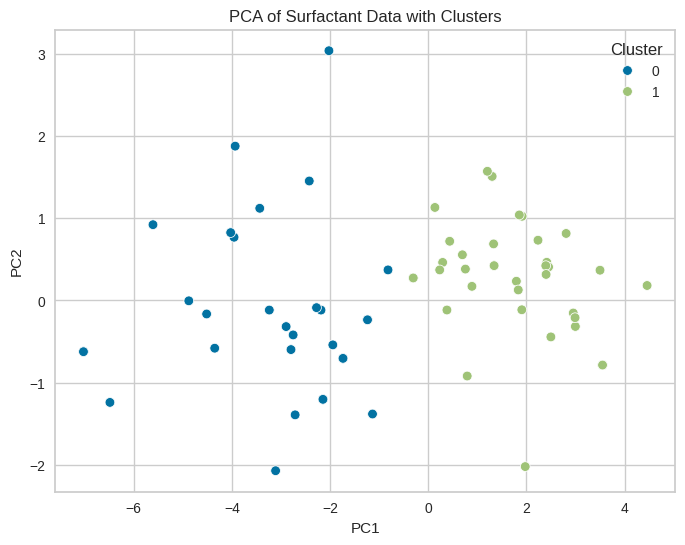

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df1 and df4 is defined

# Select relevant features
features = ['6 regions', '10 regions', 'R1', 'R2','R3', 'R4', 'R5', 'L1','L2', 'L3', 'L4', 'L5']
X = df1[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create DataFrame of principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf['Surfactant'] = df1['Surfactant']

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
principalDf['Cluster'] = kmeans.fit_predict(principalDf[['PC1', 'PC2']])

# Visualize principal components with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principalDf)
plt.title('PCA of Surfactant Data with Clusters')
plt.show()

# Calculate cluster means for each feature
# Get cluster assignments for each data point
cluster_assignments = kmeans.labels_


Feature Importance (Difference in Means):
10 regions    1.797836
6 regions     1.707448
L5            1.687833
R3            1.584264
L3            1.575718
R5            1.554819
R4            1.515623
L2            1.415023
R1            1.389293
R2            1.353254
L4            1.337315
L1            1.286482
dtype: float64


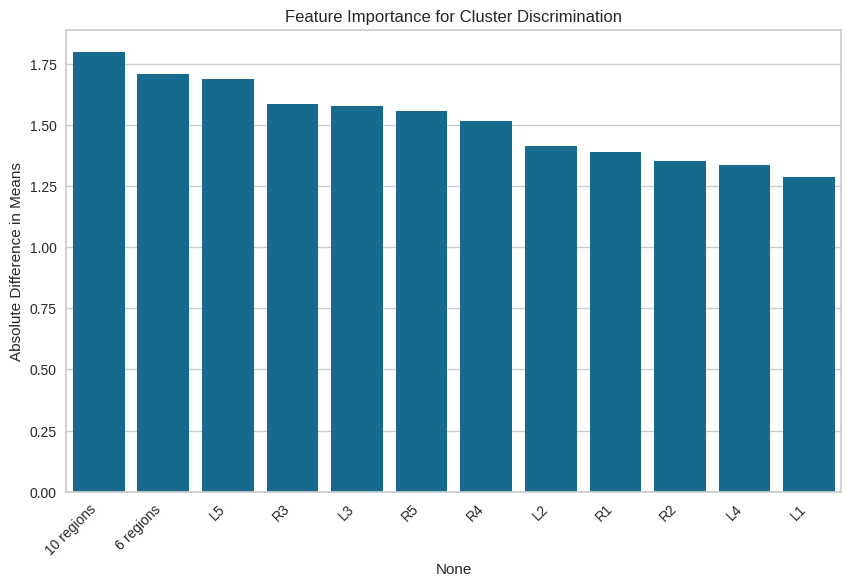

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ... (previous code for PCA and clustering) ...

# Calculate cluster means for each feature in the ORIGINAL feature space
# Get cluster assignments for each data point
cluster_assignments = kmeans.labels_

# Create a DataFrame with cluster assignments and original features
clustered_data = pd.DataFrame(X_scaled, columns=features)  # Using X_scaled
clustered_data['Cluster'] = cluster_assignments

# Calculate cluster means for the original features
cluster_means = clustered_data.groupby('Cluster').mean()

# --- Feature Importance ---
# Calculate the absolute difference in means between clusters for each feature
# ***Calculate feature_importance: subtract cluster means for each feature***
features = ['6 regions', '10 regions', 'R1', 'R2','R3', 'R4', 'R5', 'L1','L2','L3', 'L4', 'L5']
feature_importance = cluster_means.loc[1, features] - cluster_means.loc[0, features] # Difference between cluster 1 and cluster 0

# Sort features by importance (descending order) based on absolute difference
feature_importance = feature_importance.sort_values(ascending=False, key=abs)

# Print feature importance
print("\nFeature Importance (Difference in Means):")
print(feature_importance)

# --- Visualization (Optional) ---
# You can visualize the feature importance using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.index, y=feature_importance.values)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance for Cluster Discrimination')
plt.ylabel('Absolute Difference in Means')
plt.show()



# Baseline model

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 76
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Cases                  76 non-null     object  
 1   Diagnosis on patterns  76 non-null     object  
 2   6 regions              76 non-null     Int64   
 3   10 regions             76 non-null     Int64   
 4   Surfactant             76 non-null     Int64   
 5   GA                     76 non-null     Int64   
 6   R1                     76 non-null     Int64   
 7   R2                     76 non-null     Int64   
 8   R3                     76 non-null     Int64   
 9   R4                     76 non-null     Int64   
 10  R5                     76 non-null     Int64   
 11  L1                     76 non-null     Int64   
 12  L2                     76 non-null     Int64   
 13  L3                     76 non-null     Int64   
 14  L4                     76 non-null     Int64   
 

In [ ]:
df1=df1.dropna(subset=['6 regions'])

In [ ]:
y_true = df['Surfactant']

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']

Main cohort

In [ ]:
df_30_minus = df1[df1['GA'] <= 30]
df_30_plus = df1[df1['GA'] > 30]

# Choose what data you want to study
df = df1.copy()
#df = df_30_minus.copy()
#df = df_30_plus.copy()

In [ ]:
results = results[0:0]

In [ ]:
# calculate metrics of score > or <9 to predict surfactant

# The y_true should be filtered as well
#df=df.dropna(subset=['6 regions'])
# Create predictions based on the '6 regions' score
y_pred = (df['6 regions'] >= 9).astype(int)  # 1 if score >= 9, 0 otherwise

# Filter y_true to match the rows used for prediction
y_true_filtered = y_true[df.index] # using the index from the filtered DataFrame `df` to select the corresponding rows from `y_true`

youden_index= get_metrics(y_pred, y_true_filtered)
accuracy, sensitivity, specificity, youden_index,  precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)
new_data = {
   'method': 'Baseline (6 regions)  ',
   'accuracy': accuracy,
   'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'f1 score': f1,
    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.69697,0.741935,0.790169,0.78451,0.206897,0.212766


# Rule based

In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] <= 1:  # Rule 2: If L3 > 1 and R3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based ',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213


In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate  = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based no L5 ',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489


Remove L5

In [ ]:
from sklearn.metrics import make_scorer
def youden_index_scorer(y_true, y_pred):
       tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
       sensitivity = tp / (tp + fn)
       specificity = tn / (tn + fp)
       return sensitivity + specificity - 1
youden_scorer = make_scorer(youden_index_scorer)

feature selection based on Youden index

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from itertools import combinations

# Assuming df_30plus and calculate_region_metrics function are already defined

def predict_surfactant_rule_based_combination(row, regions, thresholds):
    """Predicts surfactant administration based on rules for a combination of regions."""
    # Adjust the prediction logic based on your specific rules and thresholds for the combination
    # For example, you might use majority voting, specific conditions, or other logic
    # Here's a simple example using majority voting with thresholds:

    num_regions_above_threshold = sum(row[region] > thresholds[region] for region in regions)

    if num_regions_above_threshold >= len(regions) // 2 + 1:
        return 1  # Predict surfactant
    else:
        return 0  # Predict no surfactant

# Define the regions and thresholds (adjust as needed)
regions = ['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5']
thresholds = {region: 1 for region in regions}  # Example: threshold of 1 for all regions

# Analyze all combinations of three regions for df_30plus
best_combination = None
best_youden = 0
best_fn=1
best_auc = 0

for region_combination in combinations(regions, 3):
    # Apply the rule-based prediction function to df
    df['predicted_surfactant'] = df.apply(
        predict_surfactant_rule_based_combination, axis=1, args=(list(region_combination), thresholds)
    )

    # Evaluate the model
    # Remove rows with missing values in the selected regions
    df_evaluated = df.dropna(subset=list(region_combination) + ['Surfactant'])
    youden = youden_scorer._score_func(df_evaluated['Surfactant'], df_evaluated['predicted_surfactant']) # Call the underlying scoring function directly
    auc_features = roc_auc_score(df_evaluated['Surfactant'], df_evaluated['predicted_surfactant'])

    # Update best combination if current one is better
    if  youden > best_youden:
          best_youden =  youden
          best_combination = region_combination
          best_auc = auc_features
          best_fn = fn_rate

# Print the best combination and its metrics
print(f"Best rule-based combination for df: {best_combination}")
print(f"Youden Index: {best_youden:.2f}")
print(f"AUC: {best_auc:.2f}")
print('False negative rate:', fn_rate)


# Further evaluation (sensitivity, specificity, etc.) can be added here
# ...

Best rule-based combination for df: ('L1', 'L3', 'L5')
Youden Index: 0.66
AUC: 0.83
False negative rate: 0.13793103448275862


Decsision Tree

In [ ]:
'''from sklearn.metrics import confusion_matrix

def predict_surfactant_rule_based(row, rules):
    """Predicts surfactant administration based on a list of rules."""
    for rule in rules:
        if all(row[feature] > threshold for feature, threshold in rule['conditions'].items()):
            return rule['prediction']
    return 0  # Default prediction if no rules match

def calculate_youden_index(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle potential division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle potential division by zero
    return sensitivity + specificity - 1


# Define a set of rules to test (adjust as needed)
rules_to_test = [
    # Example rules:
    {'conditions': {'L3': 1, 'L1': 1, 'L4': 1}, 'prediction': 1},  # If L3 > 1, L1 > 1, and L4 > 1, predict surfactant
    {'conditions': {'L3': 1, 'L1': 1, 'L4': 0}, 'prediction': 0},  # If L3 > 1, L1 > 1, and L4 <= 1, predict no surfactant
    {'conditions': {'L3': 1, 'L1': 0}, 'prediction': 0},           # If L3 > 1 and L1 <= 1, predict no surfactant
    {'conditions': {'L3': 0}, 'prediction': 0},                   # If L3 <= 1, predict no surfactant
    # Add more rules or modify existing ones to experiment
]


# Evaluate different combinations of rules
best_rules = []
best_youden = 0

for i in range(1, len(rules_to_test) + 1):  # Iterate through all possible combinations
    for rule_combination in combinations(rules_to_test, i):
        df['predicted_surfactant'] = df.apply(predict_surfactant_rule_based, axis=1, args=(list(rule_combination),))
        youden = calculate_youden_index(df['Surfactant'], df['predicted_surfactant'])
        if youden > best_youden:
            best_youden = youden
            best_rules = list(rule_combination)

# Print the best rules and their Youden index
print("Best Rules:")
for rule in best_rules:
    print(rule)
print(f"Youden Index: {best_youden:.2f}")

# ... (Rest of the code remains the same)'''

Best Rules:
{'conditions': {'L3': 1, 'L1': 1, 'L4': 1}, 'prediction': 1}
Youden Index: 0.45


In [ ]:
cv_folds = 5

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict

# # Define the parameter grid for Decision Tree.
param_grid = {
   'max_depth': [None, 2, 3, 4, 5],
  'min_samples_split': [2, 3, 4, 8],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'criterion': ['gini', 'entropy']
 }

# # Initialize the Decision Tree classifier.
dt = DecisionTreeClassifier(random_state=42)

# # Set up GridSearchCV with 5-fold cross-validation.
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=youden_scorer)
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation Youden:", grid_search.best_score_)

# # Get the best estimator.
best_dt = grid_search.best_estimator_

# # Use cross_val_predict with the best estimator.
y_pred_grid = cross_val_predict(best_dt, X, y, cv=5)


# # Compute metrics on the cross-validated predictions.
metrics = get_metrics(y_pred_grid, y)

new_data= {
   'method': 'Decision Tree',
  'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}



Best parameters found: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best cross-validation Youden: 0.6733333333333333


Feature selection for decision tree based on accuracy

In [ ]:
import itertools
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Decsision Tree-----
        dt = DecisionTreeClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 3, min_samples_split= 2, random_state=42)
        y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_dt, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'R1'] -> Accuracy: 0.7236842105263158 fn: 0.27586206896551724
Tested features: ['L3', 'R2'] -> Accuracy: 0.75 fn: 0.3103448275862069
Tested features: ['L3', 'R3'] -> Accuracy: 0.7763157894736842 fn: 0.20689655172413793
Tested features: ['L3', 'R4'] -> Accuracy: 0.75 fn: 0.20689655172413793
Tested features: ['L3', 'R5'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L1', 'L3'] -> Accuracy: 0.7368421052631579 fn: 0.2413793103448276
Tested features: ['L2', 'L3'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'L4'] -> Accuracy: 0.8289473684210527 fn: 0.13793103448275862
Tested features: ['L3', 'L5'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.7105263157894737 fn: 0.3448275862068966
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.7236842105263158 fn: 0.27586206896

In [ ]:
# ----- Decision Tree -----
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 3, min_samples_split= 2, random_state=42)
X=df[['L3','L4']]
y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_dt, y)
results.loc[len(results)] = {
    'method': 'Decision Tree (GridSearch)',
    'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

results


,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489


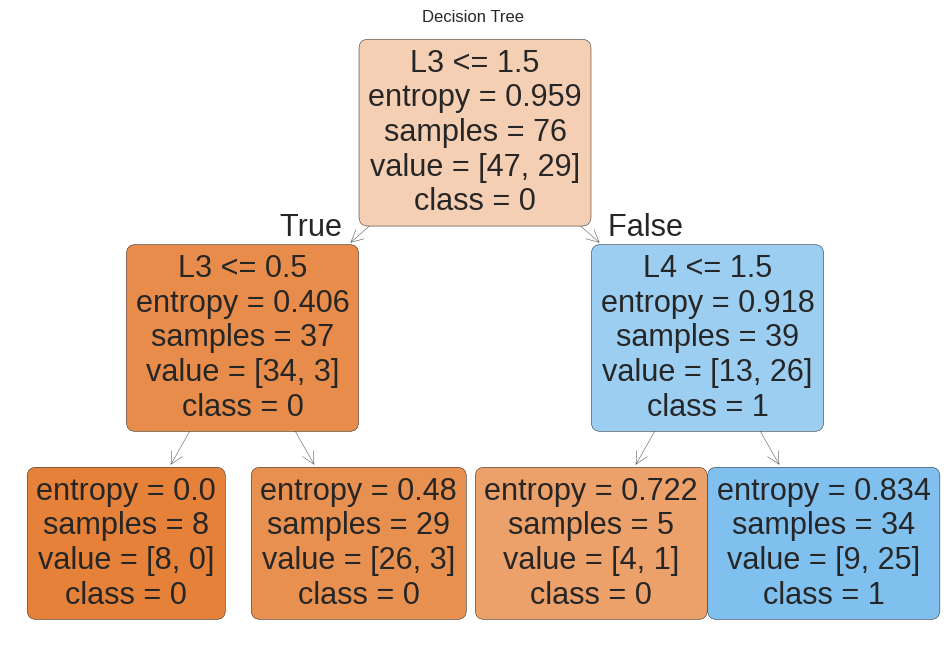

In [ ]:
# Visualize the tree
from sklearn.tree import plot_tree
# Fit the decision tree on the entire dataset
dt_full = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=2,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=42
)
dt_full.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt_full,
    feature_names=['L3', 'L4'],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree ")
plt.show()


# Logistic regression

NO feature selection

In [ ]:
X = df[features]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression no feature selection ',
     'Youden index':  metrics[1] +metrics[2] -1,
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'accuracy': metrics[3],
    'precision': metrics[4],
            'recall': metrics[5],
    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[ 0.51192986 -0.06044026 -0.08909266 -0.03600894 -0.19327768  0.69194123
  -0.23900928  0.29790488  0.7269253 ]]
Intercept: [-2.45867346]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489


Feature selection for logistic regression

In [ ]:
import itertools
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Logistic Regression -----
        lr = LogisticRegression(solver='liblinear')
        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'R1'] -> Accuracy: 0.7105263157894737 fn: 0.3103448275862069
Tested features: ['L3', 'R2'] -> Accuracy: 0.7763157894736842 fn: 0.13793103448275862
Tested features: ['L3', 'R3'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'R4'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'R5'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L1', 'L3'] -> Accuracy: 0.7236842105263158 fn: 0.27586206896551724
Tested features: ['L2', 'L3'] -> Accuracy: 0.7894736842105263 fn: 0.10344827586206896
Tested features: ['L3', 'L4'] -> Accuracy: 0.8026315789473685 fn: 0.13793103448275862
Tested features: ['L3', 'L5'] -> Accuracy: 0.8157894736842105 fn: 0.10344827586206896
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.7105263157894737 fn: 0.3103448275862069
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.69736

In [ ]:
X= df[['L3', 'L5']]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression with feature selection',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[0.96878311 0.49606353]]
Intercept: [-2.55304874]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
4,Logistic Regression with feature selection,0.815789,0.896552,0.765957,0.662509,0.702703,0.787879,0.831255,0.819364,0.103448,0.234043


Random forest

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']

In [ ]:

# ----- Random Forest -----
rf = RandomForestClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators=200, random_state=42)
y_pred_rf = cross_val_predict(rf, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_rf, y)

#AUC and AUPRC
fpr, tpr, _ = roc_curve(y_pred_rf, y)
roc_auc = auc(fpr, tpr)

results.loc[len(results)] = {
    'method': 'Random Forest ',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': roc_auc,
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
4,Logistic Regression with feature selection,0.815789,0.896552,0.765957,0.662509,0.702703,0.787879,0.831255,0.819364,0.103448,0.234043
5,Random Forest,0.750000,0.689655,0.787234,0.476889,0.666667,0.677966,0.735507,0.737371,0.310345,0.212766


Gradient boosting

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']



# ----- Gradient Boosting -----
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics= get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting ',
'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

In [ ]:
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting ',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]}


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897,0.212766
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931,0.170213
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931,0.191489
4,Logistic Regression with feature selection,0.815789,0.896552,0.765957,0.662509,0.702703,0.787879,0.831255,0.819364,0.103448,0.234043
5,Random Forest,0.750000,0.689655,0.787234,0.476889,0.666667,0.677966,0.735507,0.737371,0.310345,0.212766
6,Gradient Boosting,0.723684,0.551724,0.829787,0.381511,0.666667,0.603774,0.690756,0.694722,0.448276,0.170213


Histograms

In [ ]:
df['Histograms 4 regions'] = df['R1'] + df['L3'] + df['L5'] + df['L4']

In [ ]:
def predict_surfactant_histograms(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['Histograms 4 regions'] <= 7:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    else:
        return 1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_histograms, axis=1)

accuracy, sensitivity, specificity, youden_index, precision, recall, f1, roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Histograms',
     'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data
np.round(results,2)
results.iloc[:,:10]

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate
0,Baseline (6 regions),0.789474,0.793103,0.787234,0.580337,0.696970,0.741935,0.790169,0.784510,0.206897
1,Rule based,0.842105,0.862069,0.829787,0.691856,0.757576,0.806452,0.845928,0.836138,0.137931
2,Rule based no L5,0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931
3,Decision Tree (GridSearch),0.828947,0.862069,0.808511,0.670580,0.735294,0.793651,0.835290,0.824997,0.137931
4,Logistic Regression with feature selection,0.815789,0.896552,0.765957,0.662509,0.702703,0.787879,0.831255,0.819364,0.103448
5,Random Forest,0.750000,0.689655,0.787234,0.476889,0.666667,0.677966,0.735507,0.737371,0.310345
6,Gradient Boosting,0.723684,0.551724,0.829787,0.381511,0.666667,0.603774,0.690756,0.694722,0.448276
7,Histograms,0.776316,0.551724,0.914894,0.466618,0.800000,0.653061,0.733309,0.761388,0.448276


In [ ]:
np.round(results,2)

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions),0.79,0.79,0.79,0.58,0.70,0.74,0.79,0.78,0.21,0.21
1,Rule based,0.84,0.86,0.83,0.69,0.76,0.81,0.85,0.84,0.14,0.17
2,Rule based no L5,0.83,0.86,0.81,0.67,0.74,0.79,0.84,0.82,0.14,0.19
3,Decision Tree (GridSearch),0.83,0.86,0.81,0.67,0.74,0.79,0.84,0.82,0.14,0.19
4,Logistic Regression with feature selection,0.82,0.90,0.77,0.66,0.70,0.79,0.83,0.82,0.10,0.23
5,Random Forest,0.75,0.69,0.79,0.48,0.67,0.68,0.74,0.74,0.31,0.21
6,Gradient Boosting,0.72,0.55,0.83,0.38,0.67,0.60,0.69,0.69,0.45,0.17
7,Histograms,0.78,0.55,0.91,0.47,0.80,0.65,0.73,0.76,0.45,0.09


Cohort > 30 weeks

In [ ]:
df_30_minus = df1[df1['GA'] <= 30]
df_30_plus = df1[df1['GA'] > 30]

# Choose what data you want to study
#df = df1.copy()
#df = df_30_minus.copy()
df = df_30_plus.copy()

In [ ]:
results = results[0:0]

In [ ]:
# calculate metrics of score > or <9 to predict surfactant

# The y_true should be filtered as well
#df=df.dropna(subset=['6 regions'])
# Create predictions based on the '6 regions' score
y_pred = (df['6 regions'] >= 9).astype(int)  # 1 if score >= 9, 0 otherwise

# Filter y_true to match the rows used for prediction
y_true_filtered = y_true[df.index] # using the index from the filtered DataFrame `df` to select the corresponding rows from `y_true`

youden_index= get_metrics(y_pred, y_true_filtered)
accuracy, sensitivity, specificity, youden_index,  precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)
new_data = {
   'method': 'Baseline (6 regions) >30 weeks ',
   'accuracy': accuracy,
   'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'f1 score': f1,
    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.8125,0.3125,0.454545,0.47619,0.65625,0.536797,0.5,0.1875


# Rule based

In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] <= 1:  # Rule 2: If L3 > 1 and R3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based >30 weeks',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625


In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate  = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based no L5 >30 weeks',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625


Remove L5

In [ ]:
from sklearn.metrics import make_scorer
def youden_index_scorer(y_true, y_pred):
       tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
       sensitivity = tp / (tp + fn)
       specificity = tn / (tn + fp)
       return sensitivity + specificity - 1
youden_scorer = make_scorer(youden_index_scorer)

feature selection based on Youden index

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from itertools import combinations

# Assuming df_30plus and calculate_region_metrics function are already defined

def predict_surfactant_rule_based_combination(row, regions, thresholds):
    """Predicts surfactant administration based on rules for a combination of regions."""
    # Adjust the prediction logic based on your specific rules and thresholds for the combination
    # For example, you might use majority voting, specific conditions, or other logic
    # Here's a simple example using majority voting with thresholds:

    num_regions_above_threshold = sum(row[region] > thresholds[region] for region in regions)

    if num_regions_above_threshold >= len(regions) // 2 + 1:
        return 1  # Predict surfactant
    else:
        return 0  # Predict no surfactant

# Define the regions and thresholds (adjust as needed)
regions = ['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5']
thresholds = {region: 1 for region in regions}  # Example: threshold of 1 for all regions

# Analyze all combinations of three regions for df_30plus
best_combination = None
best_youden = 0
best_fn=1
best_auc = 0

for region_combination in combinations(regions, 3):
    # Apply the rule-based prediction function to df
    df['predicted_surfactant'] = df.apply(
        predict_surfactant_rule_based_combination, axis=1, args=(list(region_combination), thresholds)
    )

    # Evaluate the model
    # Remove rows with missing values in the selected regions
    df_evaluated = df.dropna(subset=list(region_combination) + ['Surfactant'])
    youden = youden_scorer._score_func(df_evaluated['Surfactant'], df_evaluated['predicted_surfactant']) # Call the underlying scoring function directly
    auc_features = roc_auc_score(df_evaluated['Surfactant'], df_evaluated['predicted_surfactant'])

    # Update best combination if current one is better
    if  youden > best_youden:
          best_youden =  youden
          best_combination = region_combination
          best_auc = auc_features
          best_fn = fn_rate

# Print the best combination and its metrics
print(f"Best rule-based combination for df: {best_combination}")
print(f"Youden Index: {best_youden:.2f}")
print(f"AUC: {best_auc:.2f}")
print('False negative rate:', fn_rate)


# Further evaluation (sensitivity, specificity, etc.) can be added here
# ...

Best rule-based combination for df: ('R4', 'L4', 'L5')
Youden Index: 0.46
AUC: 0.73
False negative rate: 0.4


Decsision Tree

In [ ]:
'''from sklearn.metrics import confusion_matrix

def predict_surfactant_rule_based(row, rules):
    """Predicts surfactant administration based on a list of rules."""
    for rule in rules:
        if all(row[feature] > threshold for feature, threshold in rule['conditions'].items()):
            return rule['prediction']
    return 0  # Default prediction if no rules match

def calculate_youden_index(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Handle potential division by zero
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Handle potential division by zero
    return sensitivity + specificity - 1


# Define a set of rules to test (adjust as needed)
rules_to_test = [
    # Example rules:
    {'conditions': {'L3': 1, 'L1': 1, 'L4': 1}, 'prediction': 1},  # If L3 > 1, L1 > 1, and L4 > 1, predict surfactant
    {'conditions': {'L3': 1, 'L1': 1, 'L4': 0}, 'prediction': 0},  # If L3 > 1, L1 > 1, and L4 <= 1, predict no surfactant
    {'conditions': {'L3': 1, 'L1': 0}, 'prediction': 0},           # If L3 > 1 and L1 <= 1, predict no surfactant
    {'conditions': {'L3': 0}, 'prediction': 0},                   # If L3 <= 1, predict no surfactant
    # Add more rules or modify existing ones to experiment
]


# Evaluate different combinations of rules
best_rules = []
best_youden = 0

for i in range(1, len(rules_to_test) + 1):  # Iterate through all possible combinations
    for rule_combination in combinations(rules_to_test, i):
        df['predicted_surfactant'] = df.apply(predict_surfactant_rule_based, axis=1, args=(list(rule_combination),))
        youden = calculate_youden_index(df['Surfactant'], df['predicted_surfactant'])
        if youden > best_youden:
            best_youden = youden
            best_rules = list(rule_combination)

# Print the best rules and their Youden index
print("Best Rules:")
for rule in best_rules:
    print(rule)
print(f"Youden Index: {best_youden:.2f}")

# ... (Rest of the code remains the same)'''

Best Rules:
{'conditions': {'L3': 1, 'L1': 1, 'L4': 1}, 'prediction': 1}
Youden Index: 0.45


In [ ]:
cv_folds = 5

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict

# # Define the parameter grid for Decision Tree.
param_grid = {
   'max_depth': [None, 2, 3, 4, 5],
  'min_samples_split': [2, 3, 4, 8],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'criterion': ['gini', 'entropy']
 }

# # Initialize the Decision Tree classifier.
dt = DecisionTreeClassifier(random_state=42)

# # Set up GridSearchCV with 5-fold cross-validation.
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=youden_scorer)
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation Youden:", grid_search.best_score_)

# # Get the best estimator.
best_dt = grid_search.best_estimator_

# # Use cross_val_predict with the best estimator.
y_pred_grid = cross_val_predict(best_dt, X, y, cv=5)


# # Compute metrics on the cross-validated predictions.
metrics = get_metrics(y_pred_grid, y)

new_data= {
   'method': 'Decision Tree',
  'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}



Best parameters found: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation Youden: 0.11904761904761903


Feature selection for decision tree based on accuracy

In [ ]:
import itertools
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Decsision Tree-----
        dt = DecisionTreeClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 3, min_samples_split= 2, random_state=42)
        y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_dt, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'roc_auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R1'] -> Accuracy: 0.7142857142857143 fn: 0.9
Tested features: ['L3', 'R2'] -> Accuracy: 0.6904761904761905 fn: 1.0
Tested features: ['L3', 'R3'] -> Accuracy: 0.7142857142857143 fn: 0.8
Tested features: ['L3', 'R4'] -> Accuracy: 0.7380952380952381 fn: 1.0
Tested features: ['L3', 'R5'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L1', 'L3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L2', 'L3'] -> Accuracy: 0.7142857142857143 fn: 0.9
Tested features: ['L3', 'L4'] -> Accuracy: 0.7380952380952381 fn: 0.8
Tested features: ['L3', 'L5'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.6428571428571429 fn: 0.9
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.6666666666666666 fn: 0.7
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.6904761904761905 fn: 0.9
Tested features: ['L3', 'R1', 'R5'] -> Accuracy: 0.7142857142857143 fn: 0.9
Te

In [ ]:
# ----- Decision Tree -----
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 3, min_samples_split= 2, random_state=42)
X=df[['L3','L4','L5']]
y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_dt, y)
results.loc[len(results)] = {
    'method': 'Decision Tree (GridSearch) >30 weeks',
    'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

results


,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000


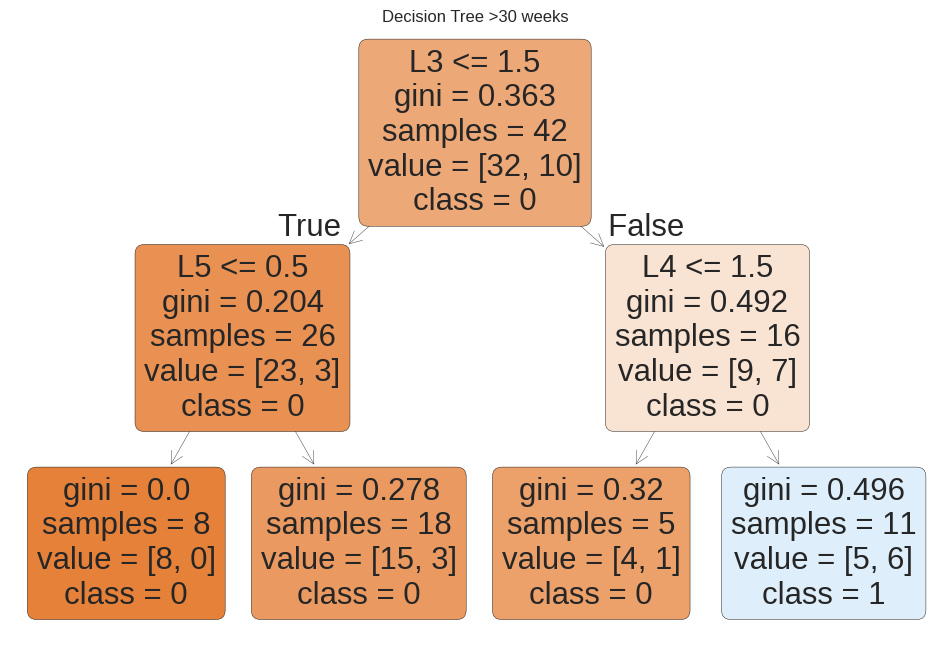

In [ ]:
# Visualize the tree
from sklearn.tree import plot_tree
# Fit the decision tree on the entire dataset
dt_full = DecisionTreeClassifier(
    criterion='gini',
    max_depth=2,
    min_samples_leaf=3,
    min_samples_split=2,
    random_state=42
)
dt_full.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt_full,
    feature_names=['L3', 'L4','L5'],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree >30 weeks")
plt.show()


# Logistic regression

NO feature selection

In [ ]:
X = df[features]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression no feature selection >30 weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[ 0.00262383 -0.38902337 -0.34938155  0.26777267  0.37136919  0.04145949
  -0.21460533 -0.02127559  0.39621242]]
Intercept: [-1.42936148]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
4,Logistic Regression no feature selection >30 w...,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000


Feature selection for logistic regression

In [ ]:
import itertools
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Logistic Regression -----
        lr = LogisticRegression(solver='liblinear')
        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'roc_auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R1'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R2'] -> Accuracy: 0.7857142857142857 fn: 0.9
Tested features: ['L3', 'R3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R4'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R5'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L1', 'L3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L2', 'L3'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'L4'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'L5'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.7857142857142857 fn: 0.9
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.7857142857142857 fn: 0.9
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.7619047619047619 fn: 1.0
Tested features: ['L3', 'R1', 'R5'] -> Accuracy: 0.7619047619047619 fn: 1.0
Te

In [ ]:
X= df[['L3', 'R1','R2']]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression with feature selection >30 weeks',

     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[ 0.87518098 -0.18150122 -0.44749209]]
Intercept: [-1.46142687]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
4,Logistic Regression no feature selection >30 w...,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
5,Logistic Regression with feature selection >30...,0.785714,0.1,1.00000,0.10000,1.000000,0.181818,NaN,0.657143,0.9,0.00000


In [ ]:
#results= results.iloc[:5,:]

Random forest

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']

In [ ]:

# ----- Random Forest -----
rf = RandomForestClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators=200, random_state=42)
y_pred_rf = cross_val_predict(rf, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_rf, y)
results.loc[len(results)] = {
    'method': 'Random Forest >30 weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
4,Logistic Regression no feature selection >30 w...,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
5,Random Forest >30 weeks,0.738095,0.0,0.96875,-0.03125,0.000000,0.000000,0.484375,0.119048,1.0,0.03125


Gradient boosting

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']



# ----- Gradient Boosting -----
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics= get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting ',
'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

In [ ]:
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting >30 weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]}


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5,0.18750
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4,0.15625
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
4,Logistic Regression no feature selection >30 w...,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0,0.00000
5,Random Forest >30 weeks,0.738095,0.0,0.96875,-0.03125,0.000000,0.000000,0.484375,0.119048,1.0,0.03125
6,Gradient Boosting >30 weeks,0.642857,0.2,0.78125,-0.01875,0.222222,0.210526,0.490625,0.306349,0.8,0.21875


Histograms

In [ ]:
df['Histograms 4 regions'] = df['R1'] + df['L3'] + df['L5'] + df['L4']

In [ ]:
def predict_surfactant_histograms(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['Histograms 4 regions'] <= 7:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    else:
        return 1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_histograms, axis=1)

accuracy, sensitivity, specificity, youden_index, precision, recall, f1, roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Histograms >30 weeks',
     'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data
np.round(results,2)
results.iloc[:,:10]

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate
0,Baseline (6 regions) >30 weeks,0.738095,0.5,0.81250,0.31250,0.454545,0.476190,0.656250,0.536797,0.5
1,Rule based >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4
2,Rule based no L5 >30 weeks,0.785714,0.6,0.84375,0.44375,0.545455,0.571429,0.721875,0.620346,0.4
3,Decision Tree (GridSearch) >30 weeks,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0
4,Logistic Regression no feature selection >30 w...,0.761905,0.0,1.00000,0.00000,0.000000,0.000000,0.500000,0.619048,1.0
5,Random Forest >30 weeks,0.738095,0.0,0.96875,-0.03125,0.000000,0.000000,0.484375,0.119048,1.0
6,Gradient Boosting >30 weeks,0.642857,0.2,0.78125,-0.01875,0.222222,0.210526,0.490625,0.306349,0.8
7,Histograms >30 weeks,0.738095,0.2,0.90625,0.10625,0.400000,0.266667,0.553125,0.395238,0.8


In [ ]:
np.round(results,2)

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) >30 weeks,0.74,0.5,0.81,0.31,0.45,0.48,0.66,0.54,0.5,0.19
1,Rule based >30 weeks,0.79,0.6,0.84,0.44,0.55,0.57,0.72,0.62,0.4,0.16
2,Rule based no L5 >30 weeks,0.79,0.6,0.84,0.44,0.55,0.57,0.72,0.62,0.4,0.16
3,Decision Tree (GridSearch) >30 weeks,0.76,0.0,1.00,0.00,0.00,0.00,0.50,0.62,1.0,0.00
4,Logistic Regression no feature selection >30 w...,0.76,0.0,1.00,0.00,0.00,0.00,0.50,0.62,1.0,0.00
5,Random Forest >30 weeks,0.74,0.0,0.97,-0.03,0.00,0.00,0.48,0.12,1.0,0.03
6,Gradient Boosting >30 weeks,0.64,0.2,0.78,-0.02,0.22,0.21,0.49,0.31,0.8,0.22
7,Histograms >30 weeks,0.74,0.2,0.91,0.11,0.40,0.27,0.55,0.40,0.8,0.09


Cohort < 3o weeks

## Decision Tree

In [ ]:
df_30_minus = df1[df1['GA'] <= 30]
df_30_plus = df1[df1['GA'] > 30]

# Choose what data you want to study
#df = df1.copy()
df = df_30_minus.copy()
#df = df_30_plus.copy()

In [ ]:
results = results[0:0]

In [ ]:
# calculate metrics of score > or <9 to predict surfactant

# The y_true should be filtered as well
#df=df.dropna(subset=['6 regions'])
# Create predictions based on the '6 regions' score
y_pred = (df['6 regions'] >= 9).astype(int)  # 1 if score >= 9, 0 otherwise

# Filter y_true to match the rows used for prediction
y_true_filtered = y_true[df.index] # using the index from the filtered DataFrame `df` to select the corresponding rows from `y_true`

youden_index= get_metrics(y_pred, y_true_filtered)
accuracy, sensitivity, specificity, youden_index,  precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)
new_data = {
   'method': 'Baseline (6 regions) ≤30 weeks ',
   'accuracy': accuracy,
   'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'f1 score': f1,
    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667


# Rule based

In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] <= 1:  # Rule 2: If L3 > 1 and R3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based ≤30 weeks',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000


In [ ]:
def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_rule_based, axis=1)

accuracy,sensitivity, specificity, youden_index, precision, recall, f1,  roc_auc, pr_auc, fn_rate, fp_rate  = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Rule based no L5 ≤30 weeks',
    'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667


Remove L5

In [ ]:
from sklearn.metrics import make_scorer
def youden_index_scorer(y_true, y_pred):
       tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
       sensitivity = tp / (tp + fn)
       specificity = tn / (tn + fp)
       return sensitivity + specificity - 1
youden_scorer = make_scorer(youden_index_scorer)

In [ ]:
cv_folds = 5

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_predict

# # Define the parameter grid for Decision Tree.
param_grid = {
   'max_depth': [None, 2, 3, 4, 5],
  'min_samples_split': [2, 3, 4, 8],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'criterion': ['gini', 'entropy']
 }

# # Initialize the Decision Tree classifier.
dt = DecisionTreeClassifier(random_state=42)

# # Set up GridSearchCV with 5-fold cross-validation.
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=youden_scorer)
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation Youden:", grid_search.best_score_)

# # Get the best estimator.
best_dt = grid_search.best_estimator_

# # Use cross_val_predict with the best estimator.
y_pred_grid = cross_val_predict(best_dt, X, y, cv=5)


# # Compute metrics on the cross-validated predictions.
metrics = get_metrics(y_pred_grid, y)

new_data= {
   'method': 'Decision Tree ≤30 weeks',
  'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}



Best parameters found: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation Youden: 0.5666666666666667


Feature selection for decision tree based on accuracy

In [ ]:
import itertools
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Decsision Tree-----
        dt = DecisionTreeClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 2, min_samples_split= 2, random_state=42)
        y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_dt, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'roc_auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'R1'] -> Accuracy: 0.8235294117647058 fn: 0.10526315789473684
Tested features: ['L3', 'R2'] -> Accuracy: 0.7941176470588235 fn: 0.15789473684210525
Tested features: ['L3', 'R3'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'R4'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'R5'] -> Accuracy: 0.8235294117647058 fn: 0.10526315789473684
Tested features: ['L1', 'L3'] -> Accuracy: 0.7941176470588235 fn: 0.15789473684210525
Tested features: ['L2', 'L3'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'L4'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'L5'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.8235294117647058 fn: 0.10526315789473684
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.8235294117647058 fn: 0.10526315789473684
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.8235294

In [ ]:
# ----- Decision Tree -----
dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 2, min_samples_split= 2, random_state=42)
X=df[['L3','L4']]
y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_dt, y)
results.loc[len(results)] = {
    'method': 'Decision Tree (GridSearch) ≤ 3o weeks',
    'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

results


,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667


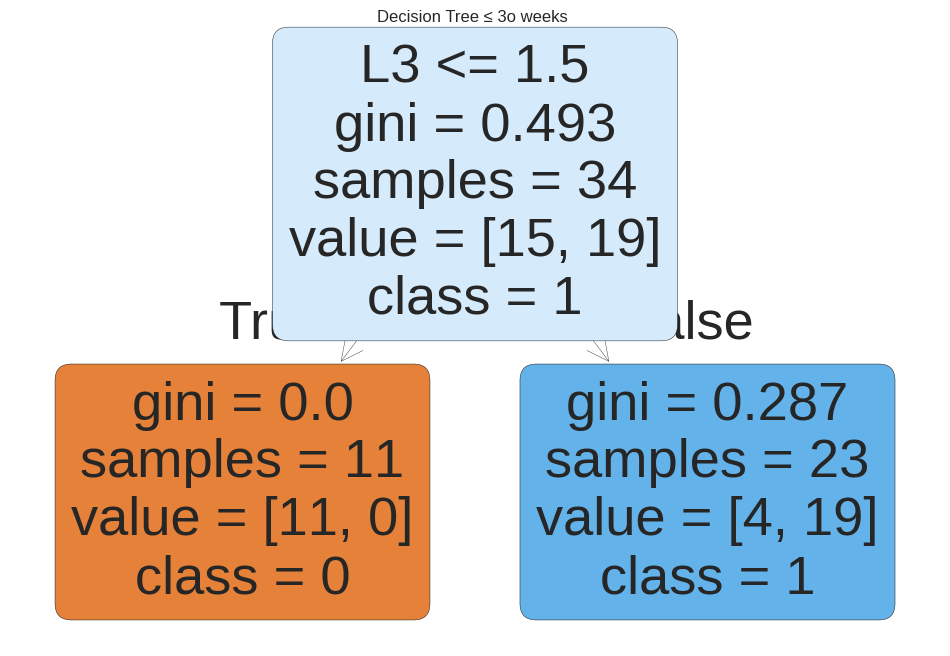

In [ ]:
# Visualize the tree
from sklearn.tree import plot_tree
# Fit the decision tree on the entire dataset
dt_full = DecisionTreeClassifier(
    criterion='gini',
    max_depth=2,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=42
)
dt_full.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt_full,
    feature_names=['L3', 'L4'],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree ≤ 3o weeks ")
plt.show()


# Logistic regression

NO feature selection

In [ ]:
X = df[features]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression no feature selection ≤ 3o weeks',
     'Youden index':  metrics[1] +metrics[2] -1,
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'accuracy': metrics[3],
    'precision': metrics[4],
            'recall': metrics[5],
    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[ 0.73185921  0.01131028 -0.27764814 -0.21329022 -0.22637184  0.47414349
   0.13093713 -0.05986205  0.98812329]]
Intercept: [-1.66218016]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
4,Logistic Regression no feature selection ≤ 3o ...,0.561404,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333


Feature selection for logistic regression

In [ ]:
import itertools
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy= 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Logistic Regression -----
        lr = LogisticRegression(solver='liblinear')
        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[9]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'roc_auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy, 'fn:', metrics[9])

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)

Tested features: ['L3'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L3', 'R1'] -> Accuracy: 0.7941176470588235 fn: 0.0
Tested features: ['L3', 'R2'] -> Accuracy: 0.8235294117647058 fn: 0.05263157894736842
Tested features: ['L3', 'R3'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'R4'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'R5'] -> Accuracy: 0.8235294117647058 fn: 0.0
Tested features: ['L1', 'L3'] -> Accuracy: 0.8823529411764706 fn: 0.0
Tested features: ['L2', 'L3'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'L4'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'L5'] -> Accuracy: 0.8529411764705882 fn: 0.0
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.7647058823529411 fn: 0.05263157894736842
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.7941176470588235 fn: 0.0
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.7941176470588235 fn: 0.0
Tested features: ['L3', 'R1', 'R5'] -> Accurac

In [ ]:
X= df[['L1', 'L3']]

In [ ]:
# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)
results.loc[len(results)] = {
    'method': 'Logistic Regression with feature selection ≤ 3o weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [[0.7557115  0.71782543]]
Intercept: [-1.75454827]


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
4,Logistic Regression no feature selection ≤ 3o ...,0.561404,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333
5,Logistic Regression with feature selection ≤ 3...,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667


Random forest

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']

In [ ]:

# ----- Random Forest -----
rf = RandomForestClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators=200, random_state=42)
y_pred_rf = cross_val_predict(rf, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_rf, y)
results.loc[len(results)] = {
    'method': 'Random Forest <30 weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]

}

results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
4,Logistic Regression no feature selection ≤ 3o ...,0.561404,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333
5,Logistic Regression with feature selection ≤ 3...,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
6,Random Forest <30 weeks,0.794118,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333


Gradient boosting

In [ ]:
# features = ['Maternal Antenatal steroids (Complete/Incomplete/Unknown)', 'GA',
#             'R1', 'R2', 'R3', 'R4', 'R5',
#             'L1', 'L2', 'L3', 'L4', 'L5']
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
# features = ['L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']



# ----- Gradient Boosting -----
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics= get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting ',
'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

In [ ]:
gb = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_leaf= 3, min_samples_split= 2, n_estimators= 100, random_state=42)
y_pred_gb = cross_val_predict(gb, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_gb, y)
results.loc[len(results)] = {
    'method': 'Gradient Boosting ≤ 3o weeks',
     'accuracy': metrics[0],
           'sensitivity': metrics[1],
    'specificity':metrics[2],
    'Youden index':  metrics[3] ,
    'precision': metrics[4],

    'f1 score': metrics[6],
    'auc': metrics[7],
    'auprc': metrics[8],
    'fn rate': metrics[9],
    'fp rate': metrics[10]}


In [ ]:
results

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632,0.266667
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000,0.200000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
4,Logistic Regression no feature selection ≤ 3o ...,0.561404,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333
5,Logistic Regression with feature selection ≤ 3...,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000,0.266667
6,Random Forest <30 weeks,0.794118,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333
7,Gradient Boosting ≤ 3o weeks,0.794118,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263,0.333333


Histograms

In [ ]:
df['Histograms 4 regions'] = df['R1'] + df['L3'] + df['L5'] + df['L4']

In [ ]:
def predict_surfactant_histograms(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['Histograms 4 regions'] <= 7:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    else:
        return 1  # Handle cases not covered by the rules (you might want to adjust this)'''

# Ensure y_true and y_pred are based on the same DataFrame
y_true_filtered = df['Surfactant']  # Use df, not the original y_true
y_pred = df.apply(predict_surfactant_histograms, axis=1)

accuracy, sensitivity, specificity, youden_index, precision, recall, f1, roc_auc, pr_auc, fn_rate, fp_rate = get_metrics(y_pred, y_true_filtered)  # Pass filtered y_true
new_data = {
    'method': 'Histograms',
     'sensitivity': sensitivity,
    'specificity': specificity,
    'Youden index': sensitivity + specificity - 1,  # Calculate Youden here
    'accuracy': accuracy,
    'precision': precision,
    # 'recall': recall,
    'f1 score': f1,

    'auc': roc_auc,
    'auprc': pr_auc,
    'fn rate': fn_rate,
    'fp rate': fp_rate
}

results.loc[len(results)] = new_data
np.round(results,2)
results.iloc[:,:10]

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate
0,Baseline (6 regions) ≤30 weeks,0.852941,0.947368,0.733333,0.680702,0.818182,0.878049,0.840351,0.897481,0.052632
1,Rule based ≤30 weeks,0.911765,1.000000,0.800000,0.800000,0.863636,0.926829,0.900000,0.931818,0.000000
2,Rule based no L5 ≤30 weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000
3,Decision Tree (GridSearch) ≤ 3o weeks,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000
4,Logistic Regression no feature selection ≤ 3o ...,0.561404,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263
5,Logistic Regression with feature selection ≤ 3...,0.882353,1.000000,0.733333,0.733333,0.826087,0.904762,0.866667,0.913043,0.000000
6,Random Forest <30 weeks,0.794118,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263
7,Gradient Boosting ≤ 3o weeks,0.794118,0.894737,0.666667,0.561404,0.772727,0.829268,0.780702,0.863144,0.105263
8,Histograms,0.823529,0.736842,0.933333,0.670175,0.933333,0.823529,0.835088,0.908617,0.263158


In [ ]:
np.round(results,2)

,method,accuracy,sensitivity,specificity,Youden index,precision,f1 score,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) ≤30 weeks,0.85,0.95,0.73,0.68,0.82,0.88,0.84,0.90,0.05,0.27
1,Rule based ≤30 weeks,0.91,1.00,0.80,0.80,0.86,0.93,0.90,0.93,0.00,0.20
2,Rule based no L5 ≤30 weeks,0.88,1.00,0.73,0.73,0.83,0.90,0.87,0.91,0.00,0.27
3,Decision Tree (GridSearch) ≤ 3o weeks,0.88,1.00,0.73,0.73,0.83,0.90,0.87,0.91,0.00,0.27
4,Logistic Regression no feature selection ≤ 3o ...,0.56,0.89,0.67,0.56,0.77,0.83,0.78,0.86,0.11,0.33
5,Logistic Regression with feature selection ≤ 3...,0.88,1.00,0.73,0.73,0.83,0.90,0.87,0.91,0.00,0.27
6,Random Forest <30 weeks,0.79,0.89,0.67,0.56,0.77,0.83,0.78,0.86,0.11,0.33
7,Gradient Boosting ≤ 3o weeks,0.79,0.89,0.67,0.56,0.77,0.83,0.78,0.86,0.11,0.33
8,Histograms,0.82,0.74,0.93,0.67,0.93,0.82,0.84,0.91,0.26,0.07


# Results:
Results:
Univariate analysis (supplemental material 1) showed a bimodal distribution of GA,  mean GA = 30.5 weeks (25 to 34 weeks, median 31 weeks) with two well balanced groups : ≤ 30 weeks and >30 weeks. Six-region score had a left skewed distribution with a mean= 7.3 and a median = 8. Ten-region score had a bimodal distribution with a mean =13.2 and a median=15. Pattern diagnosis was TTN for 30 babies (sensitivity 55% and specificity 86%) and RDS for 44 patients  (sensitivity 86% and specificity 61%). The expert was unable to conclude for 4 patients. Histograms showed the distribution of the regional score, in the global population and within each subclass  (receiving or not receiving surfactant) (Figure 1). For the global population, most patients scored 1 in anterior regions (R1, R2, L1, L2) and scored 2 in axillary and posterior regions (R3, L3, R4, L4, R5 and L5). For patients not receiving surfactant, they mainly scored 1 in all regions except in R5 and L5. For patients receiving surfactant, they mainly  scored 2 in all regions. Differences between regions between the 2 classes are shown in Figure 1D. Bivariate analysis on a heatmap is  shown on Figure 2. Spearman heatmaps indicated the strongest correlations with surfactant administration were in L3, L4, and L5. Heatmap also highlighted multiple linear correlations between regions which are highlighted in supplemental material 2 and were used for features selection.
PCA analysis:
PCA identified L5, R3, and L3 as the top contributors. (Supplemental material 4). Involvement of these 3 regions together and other combinations selected from other models (logistic regression, histograms and rule-based) were also tested. PCA 3 regions (threshold = 6, Youden index = 0.57) and Histograms 4 regions (cut off = 7, Youden index = 0.58) contributed more than the six-region model.
Rule-based model (Figure 3A):
The rule-based model was based on binary predictions: if a region score was ≤ 1, the patient was allocated to no surfactant class, if the score was >1, the patient was allocated to another region’s score or to surfactant treatment. Best combinations for binary predictions involving 2, 3 and 4 regions are displayed in Table 1. The rule-based model using L3, L4, and L5 achieved an accuracy of 0.84 and FNR of 0.14.
Rule-based models were then developed based on best combinations, after taking into account collinearity between regions. First two steps aimed at identifying patients not requiring surfactant (regions L3 and L5), followed by a final decision to identify patients needing treatment (region L4). As L5 classified only 2 patients, we tested the model after excluding L5, which remained good with accuracy 0.67 and FNR  0.14.
Decision tree model (Supplemental material 3):
A Decision tree model was developed, with and without feature selection, and the following parameters were selected after GridSearch: criterion = 'entropy' max_depth = 2 min_samples_leaf = 3 min_samples_split = 2. The best combination based on the accuracy was L3 and L4 (accuracy 0.83 and false negative rate = 0.10) (supplemental material 3). Performance of the model is displayed in Table 2.
Logistic regression model:
A logistic regression model was developed after feature selection. Best combinations were ‘L3, L5’, ‘L3, R2, L5’,  ‘L3, R3, L5’, ‘L3, L5, R5’  and ‘L3, L5, L2’ with accuracy 0.82  and a false negative rate 0.10.  Performance of the model based on ‘L3, L5’ is displayed in Table 2. Intercept was -2.5, 0.97 and 0.50 were L3 and L5 coefficients.
Random forest and Gradient boosting models performed well but were less practical due to complexity. Their performance is displayed in Table 2.
Summary of all models with performance metrics are presented in Table 2. Best model in terms of accuracy is the rule-based model with an accuracy of 0.84 and a FNR 0.14 compared to 0.79 and 0.20 respectively  for the six-region model.
Six regions and the Rule based model were compared on a testing set, from another UK cohort recruited at the SLURP recruiting centers. Scoring was performed by experts blinded to the new Rule-based algorithm.
≤ 30 weeks cohort (Table 1):
Subgroup analysis showed best model performance in ≤ 30-week infants.  Best features differed slightly being L3, R3 in the decision tree, and L1, L3 for the logistic regression. Rule-based model remained the more accurate model.
>30 weeks cohort (Table 1):
Performance declined in >30-week cohort but remained highest in the rule-based model. For the Decision tree, all combinations involving L3 showed the best accuracy, as for L3 alone. For the logistic regression, five combinations showed the same accuracy (0.78), which was similar to the Rule-based model. However, the FNR was lower for the latest.
Learner’s scoring (Table 1):
Rule-based and six-region model accuracies were lower than in the main cohort scored by the expert. However, the Rule-based model was more performant than the 6 regions model (accuracy 0.76 and 0.69 respectively).


Analysis of errors from Rule-based model and the Decision tree model:
From the Rule based model, 13/77 patients were allocated to the wrong treatment. Mean 6 regions and 10 regions scores were 8.5 and 15 respectively, which were the threshold for making the decision. Their mean gestational age was 31 weeks. Four patients with low scores on 6 regions (5 to 7) born at 31 and 32 weeks were wrongly predicted not to receive surfactant from both models. Fourteen patients were allocated to the wrong treatment in the Decision tree model, and their profiles were the same as the Rule -based Model. In the ≤ 30 weeks cohort, the three errors all predicted surfactant when the baby did actually not receive it based on the European recommendations. Two of them (25 and 29 weeks GA newborns) were on low flow oxygen at 36 weeks.  The errors when allocating no surfactant when surfactant was actually given occurred exclusively in the 31-34 weeks cohort. Six regions' scores were also very low (between 5 and 7), the diagnosis patterns of the global lungs were TTN for 3 and RDS for 2 of them, and the X-ray scores varied between 1 and 3.  The second errors were to predict surfactant to newborns who did not receive it. This concerned 8 babies, 3 at or less than 30 weeks and 5 above 30 weeks. The first 3 babies also had high total 6 regions scores (10 and 11), their FiO2 at the time of the first LU was 26%, their diagnosis on patterns was RDS and Chest X-ray scores were 2, 1 and 1. Two of them (the most immatures at 25 and 29 weeks) developed mild BPD and were on low flow oxygen at 36 weeks. For the 5 more mature babies, 6 region scores were between 8 and 10, just around the threshold value, their diagnosis on patterns were all RDS.


# Conclusion:


In summary, this study presents a novel, data-driven approach to predicting surfactant administration in preterm infants using lung ultrasound. By analyzing individual lung regions and their combinations, we developed three simplified models—a rule-based model, a decision tree, and a logistic regression model—that outperformed the traditional six-region score in terms of accuracy and false negative rate. The rule-based model and the decision tree are very similar.
Across all models, the left axillary (L3) and left posterior (L4, L5) regions consistently emerged as the most predictive. The rule-based model, in particular, demonstrated the highest overall performance and ease of use, especially for clinicians less experienced in lung ultrasound interpretation. Removing L5 from the model had minimal impact on performance, suggesting that a two-region approach may offer a balance between simplicity and diagnostic accuracy.
Importantly, these models are adaptable and can be retrained using local data, allowing for continuous improvement and potential application in varied clinical settings. This approach supports the integration of machine learning and real-time data analysis into neonatal care, offering a promising step toward more individualized and accessible respiratory support strategies. Ongoing work is evaluating the model’s utility in predicting additional outcomes such as the need for a second surfactant dose and the development of bronchopulmonary dysplasia.






In [ ]:
# from sklearn.model_selection import GridSearchCV, cross_val_predict

# # Define the parameter grid for Decision Tree.
# param_grid = {
#     'max_depth': [None, 2, 3, 4, 5],
#     'min_samples_split': [2, 3, 4, 8],
#     'min_samples_leaf': [1, 2, 3, 5, 10],
#     'criterion': ['gini', 'entropy']
# }

# # Initialize the Decision Tree classifier.
# dt = DecisionTreeClassifier(random_state=42)

# # Set up GridSearchCV with 5-fold cross-validation.
# grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X, y)

# print("Best parameters found:", grid_search.best_params_)
# print("Best cross-validation accuracy:", grid_search.best_score_)

# # Get the best estimator.
# best_dt = grid_search.best_estimator_

# # Use cross_val_predict with the best estimator.
# y_pred_grid = cross_val_predict(best_dt, X, y, cv=5)


# # Compute metrics on the cross-validated predictions.
# metrics = get_metrics(y_pred_grid, y)

# results.loc[len(results)] = {
#     'method': 'Decision Tree (GridSearch)',
#     'accuracy': metrics[0],
#     'precision': metrics[1],
#     'recall': metrics[2],
#     'f1 score': metrics[3],
#     'sensitivity': metrics[4],
#     'specificity': metrics[5],
#     'auc': metrics[6],
#     'auprc': metrics[7],
#     'fn rate': metrics[8],
#     'fp rate': metrics[9]
# }


## Random forest

In [ ]:
# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 2, 3, 4],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3],
#     'criterion': ['gini', 'entropy']
# }

# rf = RandomForestClassifier(random_state=42)
# grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=cv_folds, scoring='accuracy')
# grid_search_rf.fit(X, y)

# print("Best parameters for Random Forest:", grid_search_rf.best_params_)
# print("Best cross-validation accuracy for RF:", grid_search_rf.best_score_)

# best_rf = grid_search_rf.best_estimator_
# y_pred_rf = cross_val_predict(best_rf, X, y, cv=cv_folds)
# metrics_rf = get_metrics(y_pred_rf, y)

# results.loc[len(results)] = {
#     'method': 'Random Forest (GridSearch)',
#     'accuracy': metrics_rf[0],
#     'precision': metrics_rf[1],
#     'recall': metrics_rf[2],
#     'f1 score': metrics_rf[3],
#     'sensitivity': metrics_rf[4],
#     'specificity': metrics_rf[5],
#     'auc': metrics_rf[6],
#     'auprc': metrics_rf[7],
#     'fn rate': metrics_rf[8],
#     'fp rate': metrics_rf[9]
# }


## Gradient boosting

In [ ]:
# param_grid_gb = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [2, 3, 4],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3]
# }

# gb = GradientBoostingClassifier(random_state=42)
# grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=cv_folds, scoring='accuracy')
# grid_search_gb.fit(X, y)

# print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
# print("Best cross-validation accuracy for GB:", grid_search_gb.best_score_)

# best_gb = grid_search_gb.best_estimator_
# y_pred_gb = cross_val_predict(best_gb, X, y, cv=cv_folds)
# metrics_gb = get_metrics(y_pred_gb, y)

# results.loc[len(results)] = {
#     'method': 'Gradient Boosting (GridSearch)',
#     'accuracy': metrics_gb[0],
#     'precision': metrics_gb[1],
#     'recall': metrics_gb[2],
#     'f1 score': metrics_gb[3],
#     'sensitivity': metrics_gb[4],
#     'specificity': metrics_gb[5],
#     'auc': metrics_gb[6],
#     'auprc': metrics_gb[7],
#     'fn rate': metrics_gb[8],
#     'fp rate': metrics_gb[9]
# }


# Feature selection methods

Commented because didn't improve the metrics

In [ ]:
"""import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, precision_recall_curve)

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.base import BaseEstimator, TransformerMixin


features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
X = df[features]
y = df['Surfactant']

#------------------------------------------------------------------------------
# Custom transformer for correlation-based feature selection.
class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=3):
        self.k = k
    def fit(self, X, y):
        # Ensure X is a DataFrame so that we have column names.
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=features)
        correlations = {}
        for col in X.columns:
            # Compute the absolute Pearson correlation with the target.
            correlations[col] = abs(np.corrcoef(X[col], y)[0, 1])
        sorted_features = sorted(correlations, key=correlations.get, reverse=True)
        self.selected_features_ = sorted_features[:self.k]
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=features)
        return X[self.selected_features_]

#------------------------------------------------------------------------------
# Custom transformer for Lasso-based (L1) feature selection.
class LassoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=3, C=1.0, random_state=42):
        self.k = k
        self.C = C
        self.random_state = random_state
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=features)
        self.columns_ = X.columns
        # Use logistic regression with an L1 penalty as a proxy for Lasso.
        model = LogisticRegression(penalty='l1', solver='liblinear',
                                   C=self.C, random_state=self.random_state)
        model.fit(X, y)
        # Get the absolute value of the coefficients.
        coefs = np.abs(model.coef_[0])
        # Select the indices of the top k coefficients.
        indices = np.argsort(coefs)[::-1][:self.k]
        self.selected_features_ = self.columns_[indices].tolist()
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        return X[self.selected_features_]


#------------------------------------------------------------------------------
# Define the feature selection methods.
fs_methods = [
    ("Chi2", SelectKBest(score_func=chi2, k=3)),
    ("InfoGain", SelectKBest(score_func=mutual_info_classif, k=3)),
    ("Correlation", CorrelationSelector(k=3)),
    ("RFE", RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=3)),
    ("SFS", SequentialFeatureSelector(estimator=LogisticRegression(solver='liblinear'),
                                        n_features_to_select=3, direction='forward', cv=cv_folds)),
    ("Lasso", LassoSelector(k=3, C=1.0, random_state=42))
]

#------------------------------------------------------------------------------
# Define the classifiers.
classifiers = [
    # ("Logistic Regression", LogisticRegression(solver='liblinear')),
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, random_state=42))
    # ("Random Forest", RandomForestClassifier(criterion= 'gini', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators=200, random_state=42))
]

#------------------------------------------------------------------------------
# Loop over each feature selection method and classifier combination.
# For each combination, we build a pipeline that first selects the top 3 features
# and then fits the classifier. We then compute the metrics using cross_val_predict.
for fs_name, fs_obj in fs_methods:
    for clf_name, clf in classifiers:
        pipeline = Pipeline([
            ('selector', fs_obj),
            ('classifier', clf)
        ])
        y_pred = cross_val_predict(pipeline, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred, y)
        method_name = f"{fs_name} + {clf_name}"
        results.loc[len(results)] = {
            'method': method_name,
            'accuracy': metrics[0],
            'precision': metrics[1],
            'recall': metrics[2],
            'f1 score': metrics[3],
            'sensitivity': metrics[4],
            'specificity': metrics[5],
            'auc': metrics[6],
            'auprc': metrics[7],
            'fn rate': metrics[8],
            'fp rate': metrics[9]
        }
"""

'import pandas as pd\nimport numpy as np\n\nfrom sklearn.model_selection import cross_val_predict\nfrom sklearn.pipeline import Pipeline\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier\n\nfrom sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, \n                             confusion_matrix, roc_curve, auc, precision_recall_curve)\n\nfrom sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE, SequentialFeatureSelector\nfrom sklearn.base import BaseEstimator, TransformerMixin\n\n\nfeatures = [\'R1\', \'R2\', \'R3\', \'R4\', \'R5\', \n            \'L1\', \'L2\', \'L3\', \'L4\', \'L5\']\nX = df[features]\ny = df[\'Surfactant\']\n\n#------------------------------------------------------------------------------\n# Custom transformer for correlation-based feature selection.\nclass CorrelationSelector(Base

In [ ]:
!pip install boruta

In [ ]:
"""from boruta import BorutaPy

# Define your feature columns and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L3', 'L4', 'L5']
X = df[features] # Convert to numpy array
y = df['Surfactant']

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Initialize Boruta with the classifier.
# The n_estimators parameter set to 'auto' will let Boruta decide on the number of trees.
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta on your data. Boruta will create "shadow features" to evaluate the importance of each real feature.
boruta_selector.fit(X, y)

# Get the selected feature indices
selected_indices = boruta_selector.support_

# Map the indices back to the feature names
selected_features = np.array(features)[selected_indices]

print("Selected Features:", selected_features)
"""

'from boruta import BorutaPy\n\n# Define your feature columns and target variable\nfeatures = [\'R1\', \'R2\', \'R3\', \'R4\', \'R5\', \n            \'L1\', \'L2\', \'L3\', \'L4\', \'L5\']\nX = df[features] # Convert to numpy array\ny = df[\'Surfactant\']\n\n# Initialize a Random Forest classifier\nrf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)\n\n# Initialize Boruta with the classifier.\n# The n_estimators parameter set to \'auto\' will let Boruta decide on the number of trees.\nboruta_selector = BorutaPy(estimator=rf, n_estimators=\'auto\', verbose=2, random_state=42)\n\n# Fit Boruta on your data. Boruta will create "shadow features" to evaluate the importance of each real feature.\nboruta_selector.fit(X, y)\n\n# Get the selected feature indices\nselected_indices = boruta_selector.support_\n\n# Map the indices back to the feature names\nselected_features = np.array(features)[selected_indices]\n\nprint("Selected Features:", selected_features)\n'

In [ ]:
import itertools
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy = 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Logistic Regression -----
        lr = LogisticRegression(solver='liblinear')
        y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_lr, y)

        accuracy = metrics[0]  # can change to another metric than accuracy
        fn =  metrics[8]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
            'precision': metrics[1],
            # 'recall': metrics[2],
            'f1 score': metrics[3],
            'sensitivity': metrics[4],
            'specificity': metrics[5],
            'auc': metrics[6],
            'auprc': metrics[7],
            'fn rate': metrics[8],
            'fp rate': metrics[9]
        }
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy)

        # Update the best combination if the current one is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics


# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)
print("Best fn:", best_fn)


Tested features: ['L3'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R1'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R2'] -> Accuracy: 0.7857142857142857
Tested features: ['L3', 'R3'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R4'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R5'] -> Accuracy: 0.7619047619047619
Tested features: ['L1', 'L3'] -> Accuracy: 0.7619047619047619
Tested features: ['L2', 'L3'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'L4'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'L5'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.7857142857142857
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.7857142857142857
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R1', 'R5'] -> Accuracy: 0.7619047619047619
Tested features: ['L1', 'L3', 'R1'] -> Accuracy: 0.7619047619047619
Tested features: ['L2', 'L3', 'R1'] -> Accurac

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define the specific features and target variable
features = ['L3', 'L4', 'L5']
target = 'Surfactant'

# Select data using the specified features
X = df[features]
y = df[target]

# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)  # Assuming cv_folds is defined

# Get metrics (including FN)
metrics = get_metrics(y_pred_lr, y)  # Assuming get_metrics is defined

# Extract the false negative rate
fn_rate = metrics[8]

print("False Negative Rate for L3, L4, L5:", fn_rate)

False Negative Rate for L3, L4, L5: 1.0


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define the specific features and target variable
features = ['L3', 'L4', 'L2']
target = 'Surfactant'

# Select data using the specified features
X = df[features]
y = df[target]

# ----- Logistic Regression -----
lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)  # Assuming cv_folds is defined

# Get metrics (including FN)
metrics = get_metrics(y_pred_lr, y)  # Assuming get_metrics is defined

# Extract the false negative rate
fn_rate = metrics[8]

print("False Negative Rate for L3, L4, L2:", fn_rate)

False Negative Rate for L3, L4, L2: 1.0


In [ ]:
import itertools
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Define all features and target variable
features = ['R1', 'R2', 'R3', 'R4', 'R5',
            'L1', 'L2', 'L4', 'L5']
target = 'Surfactant'

# Create a list of features excluding L3 (which we always want to include)
other_features = [f for f in features if f != 'L3']

# Initialize variables to store the best combination
best_accuracy = 0
best_fn = 1
best_features = None
best_metrics = None

# List to store all results (optional, for further inspection)
results_list = []

# Iterate over combinations: we want at most 3 features total.
# Since L3 must be included, we choose 0, 1, or 2 additional features.
for k in range(0, 3):  # k additional features (total features = k + 1)
    for combo in itertools.combinations(other_features, k):
        # Always include 'L3'
        current_features = list(combo) + ['L3']
        current_features.sort()  # optional: sort for consistency

        # Select data using the current feature set
        X = df[current_features]
        y = df[target]

        # ----- Decision Tree -----
        dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, random_state=42)
        y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
        metrics = get_metrics(y_pred_dt, y)

        accuracy = metrics[0]  # can change to another metric
        fn = metrics[8]

        # Save the current result for further analysis if needed
        result = {
            'features': current_features,
            'accuracy': metrics[0],
            'precision': metrics[1],
            # 'recall': metrics[2],
            'f1 score': metrics[3],
            'sensitivity': metrics[4],
            'specificity': metrics[5],
            'auc': metrics[6],
            'auprc': metrics[7],
            'fn rate': metrics[8],
            'fp rate': metrics[9]
        }
        results_list.append(result)
        print("Tested features:", current_features, "-> Accuracy:", accuracy)

        # Update the best combination if the current one is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = current_features
            best_metrics = metrics

        elif accuracy == best_accuracy and fn < best_fn:
            best_accuracy = accuracy
            best_fn = fn
            best_features = current_features
            best_metrics = metrics

# Optionally, convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

print("\nBest feature combination:", best_features)
print("Best accuracy:", best_accuracy)



Tested features: ['L3'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R1'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R2'] -> Accuracy: 0.6904761904761905
Tested features: ['L3', 'R3'] -> Accuracy: 0.6904761904761905
Tested features: ['L3', 'R4'] -> Accuracy: 0.7380952380952381
Tested features: ['L3', 'R5'] -> Accuracy: 0.7619047619047619
Tested features: ['L1', 'L3'] -> Accuracy: 0.6904761904761905
Tested features: ['L2', 'L3'] -> Accuracy: 0.7142857142857143
Tested features: ['L3', 'L4'] -> Accuracy: 0.7142857142857143
Tested features: ['L3', 'L5'] -> Accuracy: 0.7142857142857143
Tested features: ['L3', 'R1', 'R2'] -> Accuracy: 0.6904761904761905
Tested features: ['L3', 'R1', 'R3'] -> Accuracy: 0.7380952380952381
Tested features: ['L3', 'R1', 'R4'] -> Accuracy: 0.7619047619047619
Tested features: ['L3', 'R1', 'R5'] -> Accuracy: 0.7619047619047619
Tested features: ['L1', 'L3', 'R1'] -> Accuracy: 0.6904761904761905
Tested features: ['L2', 'L3', 'R1'] -> Accurac

In [ ]:
X = df[['L3', 'L4', 'R3']]


lr = LogisticRegression(solver='liblinear')
y_pred_lr = cross_val_predict(lr, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_lr, y)

results.loc[len(results)] = {
    'method': 'Logistic Regression - feature selection',
    'accuracy': metrics[0],
    'precision': metrics[1],
    # 'recall': metrics[2],
    'f1 score': metrics[3],
    'sensitivity': metrics[4],
    'specificity': metrics[5],
    'auc': metrics[6],
    'auprc': metrics[7],
    'fn rate': metrics[8],
    'fp rate': metrics[9]
}

In [ ]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X, y)  # Fit the model on the entire dataset

# Access the coefficients
coefficients = lr.coef_
intercept = lr.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Coeff from ['L3', 'L4', 'R3']

Coefficients: [[ 0.88625891 -0.04148564 -0.44986215]]
Intercept: [-1.48500486]


In [ ]:
X = df[['L3', 'L4']]


dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, random_state=42)
y_pred_dt = cross_val_predict(dt, X, y, cv=cv_folds)
metrics = get_metrics(y_pred_dt, y)


results.loc[len(results)] = {
    'method': 'Decision Tree - feature selection >30 weeks',
    'accuracy': metrics[0],
    'precision': metrics[1],
    # 'recall': metrics[2],
    'f1 score': metrics[3],
    'sensitivity': metrics[4],
    'specificity': metrics[5],
    'auc': metrics[6],
    'auprc': metrics[7],
    'fn rate': metrics[8],
    'fp rate': metrics[9]
}


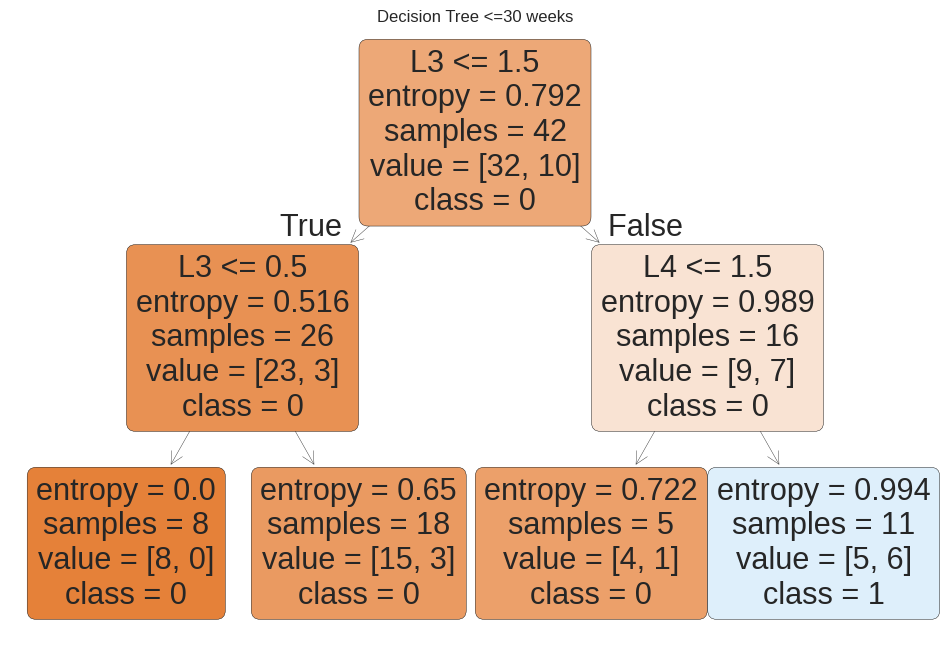

In [ ]:
# Visualize the tree
from sklearn.tree import plot_tree
# Fit the decision tree on the entire dataset
dt_full = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=2,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
dt_full.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 8))
plot_tree(
    dt_full,
    feature_names=['L3', 'L4'],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree >30 weeks")
plt.show()


In [ ]:
results

,method,accuracy,precision,f1 score,sensitivity,specificity,auc,auprc,fn rate,fp rate
0,Baseline (6 regions) <=30 weeks,0.828571,0.782609,0.857143,0.947368,0.68750,0.817434,0.879274,0.052632,0.31250
1,Rule based <=30 weeks,0.914286,0.863636,0.926829,1.000000,0.81250,0.906250,0.931818,0.000000,0.18750
2,Decision Tree <=30 weeks,0.831169,0.735294,0.793651,0.862069,0.81250,0.837284,0.824656,0.137931,0.18750
3,Random Forest <=30 weeks,0.831169,0.735294,0.793651,0.862069,0.81250,0.837284,0.824656,0.137931,0.18750
4,Gradient Boosting <=30 weeks,0.831169,0.735294,0.793651,0.862069,0.81250,0.837284,0.824656,0.137931,0.18750
5,Logistic Regression - feature selection,0.800000,0.730769,0.844444,1.000000,0.56250,0.781250,0.865385,0.000000,0.43750
6,Decision Tree - feature selection,0.828571,0.760000,0.863636,1.000000,0.62500,0.812500,0.880000,0.000000,0.37500
7,Decision Tree - feature selection <=30 weeks,0.828571,0.760000,0.863636,1.000000,0.62500,0.812500,0.880000,0.000000,0.37500
8,Decision Tree >30 weeks,0.828571,0.760000,0.863636,1.000000,0.62500,0.812500,0.880000,0.000000,0.37500
9,Random Forest >30 weeks,0.885714,0.826087,0.904762,1.000000,0.75000,0.875000,0.913043,0.000000,0.25000


# Study errors of the 2 selected models

# Rule based

In [ ]:

def predict_surfactant_rule_based(row):
    """Predicts surfactant administration based on rules for L3, L5, and L4."""
    if row['L3'] <= 1:  # Rule 1: If L3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] <= 1:  # Rule 2: If L3 > 1 and R3 <= 0, predict no surfactant
        return 0
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] > 1:  # Rule 3: If L3 > 1, R3 > 1, and L4 > 1, predict surfactant
        return 1
    elif row['L3'] > 1 and row['L5'] > 1 and row['L4'] <= 1:  # Rule 4: If L3 > 1, R3 > 1, and L4 <= 1, predict no surfactant
        return 0
    '''else:
        return -1  # Handle cases not covered by the rules (you might want to adjust this)'''

y_pred = df.apply(predict_surfactant_rule_based, axis=1)



In [ ]:
# Add the prediction as a new column to the DataFrame
df['y_pred_rule_based'] = y_pred

In [ ]:
false_df = df[df['y_pred_rule_based'] != df['Surfactant']]
false_df

1,Cases,Diagnosis on patterns,Maternal Antenatal steroids (Complete/Incomplete/Unknown),6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5,6_regions_group,y_pred_rule_based
3,5,RDS,2,10,18,0,32,2,1,2,2,2,1,2,2,2,2,>=9,1
5,7,RDS,1,10,18,0,29,1,1,2,2,2,2,2,2,2,2,>=9,1
11,15,RDS,0,8,16,0,33,1,1,2,2,2,1,1,2,2,2,<9,1
12,16,RDS,1,11,19,0,25,1,2,2,2,2,2,2,2,2,2,>=9,1
18,22,RDS,0,12,20,0,31,2,2,2,2,2,2,2,2,2,2,>=9,1
46,53,RDS,1,11,19,0,30,2,2,2,2,2,1,2,2,2,2,>=9,1
50,57,RDS,1,9,16,1,33,1,2,2,2,2,1,1,2,1,2,<9,0
53,60,RDS,1,8,16,0,33,1,1,2,2,2,1,1,2,2,2,<9,1
54,61,RDS,1,9,18,0,32,1,2,1,2,2,1,2,2,2,3,<9,1
61,68,TTN,1,5,9,1,32,1,0,1,1,1,1,1,1,1,1,<9,0


In [ ]:
false_df.describe()

1,Maternal Antenatal steroids (Complete/Incomplete/Unknown),6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5,y_pred_rule_based
count,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.000000
mean,0.769231,8.538462,15.846154,0.384615,31.076923,1.230769,1.307692,1.615385,1.846154,1.846154,1.230769,1.461538,1.692308,1.692308,1.923077,0.615385
std,0.599145,2.295481,3.508232,0.50637,2.177978,0.438529,0.630425,0.650444,0.375534,0.375534,0.438529,0.518875,0.480384,0.480384,0.493548,0.506370
min,0.0,5.0,9.0,0.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
25%,0.0,7.0,15.0,0.0,31.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,0.000000
50%,1.0,9.0,16.0,0.0,32.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.000000
75%,1.0,10.0,18.0,1.0,32.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.000000
max,2.0,12.0,20.0,1.0,33.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.000000


# Decision tree

In [ ]:
# Add the prediction as a new column to the DataFrame
df['y_pred_dt'] = y_pred_dt

In [ ]:
false_df = df[df['y_pred_dt'] != df['Surfactant']]
false_df

1,Cases,Diagnosis on patterns,Maternal Antenatal steroids (Complete/Incomplete/Unknown),6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5,6_regions_group,y_pred_rule_based,y_pred_dt
3,5,RDS,2,10,18,0,32,2,1,2,2,2,1,2,2,2,2,>=9,1,1.0
5,7,RDS,1,10,18,0,29,1,1,2,2,2,2,2,2,2,2,>=9,1,1.0
11,15,RDS,0,8,16,0,33,1,1,2,2,2,1,1,2,2,2,<9,1,1.0
12,16,RDS,1,11,19,0,25,1,2,2,2,2,2,2,2,2,2,>=9,1,1.0
18,22,RDS,0,12,20,0,31,2,2,2,2,2,2,2,2,2,2,>=9,1,1.0
46,53,RDS,1,11,19,0,30,2,2,2,2,2,1,2,2,2,2,>=9,1,1.0
50,57,RDS,1,9,16,1,33,1,2,2,2,2,1,1,2,1,2,<9,0,0.0
53,60,RDS,1,8,16,0,33,1,1,2,2,2,1,1,2,2,2,<9,1,1.0
54,61,RDS,1,9,18,0,32,1,2,1,2,2,1,2,2,2,3,<9,1,1.0
59,66,RDS,1,8,14,0,29,1,1,2,2,1,1,1,2,2,1,<9,0,1.0


In [ ]:
false_df.describe()

1,Maternal Antenatal steroids (Complete/Incomplete/Unknown),6 regions,10 regions,Surfactant,GA,R1,R2,R3,R4,R5,L1,L2,L3,L4,L5,y_pred_rule_based,y_pred_dt
count,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.000000,14.000000
mean,0.785714,8.5,15.714286,0.357143,30.928571,1.214286,1.285714,1.642857,1.857143,1.785714,1.214286,1.428571,1.714286,1.714286,1.857143,0.571429,0.642857
std,0.578934,2.210117,3.406523,0.497245,2.164905,0.425815,0.61125,0.633324,0.363137,0.425815,0.425815,0.513553,0.468807,0.468807,0.534522,0.513553,0.497245
min,0.0,5.0,9.0,0.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000
25%,0.25,7.25,14.25,0.0,30.25,1.0,1.0,1.25,2.0,2.0,1.0,1.0,1.25,1.25,2.0,0.000000,0.000000
50%,1.0,8.5,16.0,0.0,31.5,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.000000,1.000000
75%,1.0,10.0,18.0,1.0,32.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.000000,1.000000
max,2.0,12.0,20.0,1.0,33.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.000000,1.000000


Decision tree makes mistakes when 6 regions score is very close to 9 (mean 8.5)   
Moreover, GA high (mean > 30)   
Good results? Because previous method might not be 100% accurate, so it might be still "ok" not to give treatment at 10 and give treatment at 8 + might be less problematic not giving treatment for an older baby because he is stronger? + the last 4 errors must come from a doctor decision (not from the image) since the 6 regions score is very low (=5-7) and the baby was given some surfactant

In [ ]:
# create dataframe subset named df6 with  df1 with L3>1 and L4=2 and L1 =1
df[(df['L3'] > 1) & (df['L5'] <=1)]['Surfactant'].value_counts()


,count
Surfactant,
0,2
